In [5]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot  as plt
from matplotlib import font_manager
myfont = font_manager.FontProperties(fname=r".\utils\NotoSansCJK-Black.ttc")
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings

def ignore_warn(*args, **kwargs):
    pass

from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.preprocessing import LabelEncoder
from utils.append_external_data import concat_externaldata

In [6]:
train = pd.read_csv('./dataset/training_data.csv', sep=",")
test = pd.read_csv('./dataset/public_dataset.csv', sep=",")
# print(all_data.info())

In [7]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
print(all_data.columns)

Index(['ID', '縣市', '鄉鎮市區', '路名', '土地面積', '使用分區', '移轉層次', '總樓層數', '主要用途',
       '主要建材', '建物型態', '屋齡', '建物面積', '車位面積', '車位個數', '橫坐標', '縱坐標', '備註',
       '主建物面積', '陽台面積', '附屬建物面積', '單價'],
      dtype='object')


In [8]:
"""New feature"""

### is_Top_floor
all_data['top_floor'] = np.where((all_data['總樓層數'] == all_data['移轉層次']), 1, 0)
### new_town = city + town
all_data['new_town'] = all_data['縣市'].apply(str) + '_' + all_data['鄉鎮市區'].apply(str)


In [9]:
"""One hot encoding"""
all_data["使用分區"] = all_data["使用分區"].fillna("None")
all_data.drop(['備註', 'ID'], axis=1, inplace=True)
one_hot_cols = ['主要建材', '縣市', '總樓層數', '主要用途', '車位個數', '建物型態']
all_data = pd.get_dummies(all_data, columns=one_hot_cols)
print(all_data.select_dtypes(include=['object']))


      鄉鎮市區      路名  使用分區 new_town
0      大安區  敦化南路二段  None  台北市_大安區
1      萬華區     水源路  None  台北市_萬華區
2      鳳山區     北忠街  None  高雄市_鳳山區
3      新莊區     福前街  None  新北市_新莊區
4      板橋區   文化路一段  None  新北市_板橋區
...    ...     ...   ...      ...
17622  中西區  中華西路二段  None  台南市_中西區
17623   北區     育樂街  None   台中市_北區
17624  新店區   安康路二段  None  新北市_新店區
17625  信義區  忠孝東路五段  None  台北市_信義區
17626  中和區     中正路  None  新北市_中和區

[17627 rows x 4 columns]


In [10]:
category_col = ['鄉鎮市區', '路名', '使用分區', 'new_town']
for c in category_col:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [11]:
all_data['單價'] = np.log1p(all_data['單價'])

In [12]:
all_data = concat_externaldata(all_data, "./dataset/external_data/ATM資料.csv", 'ATM資料', radius=300.0)
all_data = concat_externaldata(all_data, "./dataset/external_data/大學基本資料.csv", '大學基本資料', radius=3000.0)
all_data = concat_externaldata(all_data, "./dataset/external_data/公車站點資料.csv", '公車站點資料', radius=300.0)
all_data = concat_externaldata(all_data, "./dataset/external_data/火車站點資料.csv", '火車站點資料', radius=3000.0)
all_data = concat_externaldata(all_data, "./dataset/external_data/金融機構基本資料.csv", '金融機構基本資料', radius=1000.0)
all_data = concat_externaldata(all_data, "./dataset/external_data/便利商店.csv", '便利商店', radius=300.0)
all_data = concat_externaldata(all_data, "./dataset/external_data/高中基本資料.csv", '高中基本資料', radius=3000.0)
all_data = concat_externaldata(all_data, "./dataset/external_data/國小基本資料.csv", '國小基本資料', radius=3000.0)
all_data = concat_externaldata(all_data, "./dataset/external_data/國中基本資料.csv", '國中基本資料', radius=3000.0)
all_data = concat_externaldata(all_data, "./dataset/external_data/捷運站點資料.csv", '捷運站點資料', radius=300.0)
all_data = concat_externaldata(all_data, "./dataset/external_data/郵局據點資料.csv", '郵局據點資料', radius=1000.0)
all_data = concat_externaldata(all_data, "./dataset/external_data/腳踏車站點資料.csv", '腳踏車站點資料', radius=300.0)
all_data = concat_externaldata(all_data, "./dataset/external_data/醫療機構基本資料.csv", '醫療機構基本資料', radius=3000.0)

In [13]:
train = all_data[:ntrain]
test = all_data[ntrain:].drop(['單價'], axis=1)

In [14]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def MAPE(y, y_pred):
    return sum(abs(y_pred-y)/y)/len(y)

def Score(y, y_pred):
    y=np.expm1(y)
    y_pred=np.expm1(y_pred)
    hit_rate = np.around(np.sum(np.where(abs((y_pred-y)/y)<.1,1,0))/len(y),decimals=4)*10000
    MAPE = 1-np.sum(abs((y_pred-y)/y))/len(y)
    return hit_rate+MAPE

def Score_MAPE(y, y_pred):
    y=np.expm1(y)
    y_pred=np.expm1(y_pred)
#     hit_rate = np.around(np.sum(np.where(abs((y_pred-y)/y)<.1,1,0))/len(y),decimals=4)*10000
    MAPE = 1-np.sum(abs((y_pred-y)/y))/len(y)
    return MAPE

def Score_type(y, y_pred, h_type):
    y = np.expm1(y)
    y_pred = np.where(h_type>0,np.expm1(y_pred),0)
    hit_rate = np.around(np.sum(np.where(abs((y_pred-y)/y)<.1,1,0))/len(y),decimals=4)*10000
    MAPE = 1-np.sum(abs((y_pred-y)/y))/len(y)
    return hit_rate+MAPE

def Score_acc(y, y_pred, h_type):
    y = np.expm1(y)
    y_pred = np.where(h_type>0,np.expm1(y_pred),0)
    type_total = sum(np.where(h_type>0,1,0))
    hit_rate = np.sum(np.where(abs((y_pred-y)/y)<.1,1,0))/type_total
#     MAPE = 1-np.sum(abs((y_pred-y)/y))/len(y)
    return hit_rate#+MAPE

def Score2(y, y_pred):
    y=np.expm1(y)
    y_pred=np.expm1(y_pred)
#     hit_rate = np.around(np.sum(np.where(abs((y_pred-y)/y)<.1,1,0))/len(y),decimals=4)*10000
#     MAPE = 1-np.sum(abs((y_pred-y)/y))/len(y)
    hit_rate = np.sum(np.where(abs((y_pred-y)/y)<.1,1,0))/len(y)
    MAPE = np.around(1-np.sum(abs((y_pred-y)/y))/len(y),decimals=4)*10000
    return hit_rate+MAPE

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [15]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier
from sklearn.svm import SVR

In [16]:
y_train = train['單價']
train = train.drop(['單價'], axis=1)
X_train, X_valid, train_y, valid_y = train_test_split(train, y_train, test_size=0.1, random_state=49)#42

In [17]:
valid=[(X_valid, valid_y)]

In [21]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials , partial

In [22]:
def check_result(search_result,param_space_list_2,n,plot_val=True,plot_tid=True,output_best = True):
    search_result.sort(key=lambda x : x["result"]["loss"]) # sort by search result
    
    for k in range(n):
        print("\nTop"+str(k+1)+" result :")
        print("val : ",search_result[k]["result"]["loss"])
        for i,j in search_result[k]["misc"]["vals"].items():
            print(i,param_space_list_2[i][j[0]])
    
    if plot_tid:
        print("\n")
        for i,j in param_space_list_2.items():
            if type(j) == type([]):
#                 print(i,j)
                f, ax = plt.subplots(1)
                xs = [param_space_list_2[i][t['misc']['vals'][i][0]] for t in search_result] 
                ys = [t["tid"] for t in search_result]
                ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
                ax.set_title('$t$ $vs$ '+i, fontsize=18)
                ax.set_xlabel(i, fontsize=16)
                ax.set_ylabel('$t$', fontsize=16)
                
    if plot_val:
        print("\n")
        for i,j in param_space_list_2.items():
            if type(j) == type([]):
                print(i,j)
                f, ax = plt.subplots(1)
                xs = [param_space_list_2[i][t['misc']['vals'][i][0]] for t in search_result] 
                ys = [t['result']['loss'] for t in search_result]
                ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
                ax.set_title('$val$ $vs$ '+i, fontsize=18)
                ax.set_xlabel(i, fontsize=16)
                ax.set_ylabel('$val$', fontsize=16)
    if output_best:
        best_result_param = param_space_list_2.copy()
        for i,j in search_result[0]["misc"]["vals"].items():
            best_result_param[i] = param_space_list_2[i][j[0]]
        return best_result_param

In [45]:
param_space_list = {
    "objective" : 'reg:squaredlogerror',
    "metric" : 'mape',
    "learning_rate" : 0.01, 
    "n_estimators" : 30000,   
    "max_depth" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "max_bin" : [ 250, 255, 300, 350,375, 400,425, 450, 500, 550, 600],
    "reg_lambda" : [1e-3,0.0,0.03,0.05,0.07,0.1,0.15],
    "reg_alpha" : [1e-3,0.0,0.03,0.05,0.07,0.1,0.15],
    "subsample" : [0.5,0.6,0.7,0.8,0.9,1],
    "eta" : [0.01, 0.05, 0.1, 0.2, 0.3],
    "gamma" : [0.5, 1, 2, 3, 4, 5],
    "min_child_weight" : [0.25, 0.5, 1, 1.5, 2.0],
    "colsample_bytree" : [0.5,0.6,0.7,0.8,0.9,1.0],
}

In [46]:
param_space_hyper = {
    "objective" : 'reg:squaredlogerror',
    "metric" : 'mape',
    "learning_rate" : 0.01, 
    "n_estimators" : 30000,
    "max_depth" : hp.choice("max_depth"  , [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]), 
    "max_bin" :  hp.choice("max_bin" ,[ 250, 255, 300, 350,375, 400,425, 450, 500, 550, 600]),
    "reg_lambda" :  hp.choice("reg_lambda" ,[1e-3,0.0,0.03,0.05,0.07,0.1,0.15]),
    "reg_alpha" : hp.choice( "reg_alpha" ,[1e-3,0.0,0.03,0.05,0.07,0.1,0.15]),
    "subsample" : hp.choice("subsample", [0.5,0.6,0.7,0.8,0.9,1]),
    "eta" : hp.choice("eta", [0.01, 0.05, 0.1, 0.2, 0.3]),
    "gamma" : hp.choice("gamma", [0.5, 1, 2, 3, 4, 5]),
    "min_child_weight" : hp.choice("min_child_weight", [0.25, 0.5, 1, 1.5, 2.0]),
    "colsample_bytree" : hp.choice("colsample_bytree", [0.5,0.6,0.7,0.8,0.9,1.0]),
}

In [47]:
import datetime
def xgb_fine_tune(argsDict):
    
    model_xgb = xgb.XGBRegressor(**argsDict, early_stopping_rounds=150, verbose=1)
    
    starttime = datetime.datetime.now()
    model_xgb.fit(X_train,train_y, eval_set=valid,eval_metric='mape')
    
    endtime = datetime.datetime.now()
    print ("Step_time:{}".format(endtime - starttime))
    xgb_valid_pred = model_xgb.predict(X_valid)
    xgb_train_pred = model_xgb.predict(train)
    rmsle_train = rmsle(y_train, xgb_train_pred)
    rmsle_valid = rmsle(valid_y, xgb_valid_pred)
    Score_train = Score(y_train, xgb_train_pred)
    Score_valid = Score(valid_y, xgb_valid_pred) 
    Score_MAPE_valid = Score_MAPE(valiQd_y, xgb_valid_pred) 
    mape_train = MAPE(y_train, xgb_train_pred)
    mape_valid = MAPE(valid_y, xgb_valid_pred)
    val = Score_MAPE_valid
    
    print("rmsle_train(val) = %.4f, rmsle_valid = %.4f, mape_valid = %.4f, Score_train = %.4f, Score_valid = %.4f \n"%(rmsle_train, rmsle_valid, Score_MAPE_valid*1000, Score_train,Score_valid))
    
    return {'loss': -val, 'status': STATUS_OK}

In [48]:
trials = Trials()

algo = partial(tpe.suggest,n_startup_jobs=1)
best = fmin(xgb_fine_tune,param_space_hyper,algo=algo,max_evals=50, trials=trials)
print(best)

[0]	validation_0-mape:0.57098                         
[1]	validation_0-mape:0.56748                         
[2]	validation_0-mape:0.56398                         
[3]	validation_0-mape:0.56046                         
[4]	validation_0-mape:0.55699                         
[5]	validation_0-mape:0.55353                         
[6]	validation_0-mape:0.55004                         
[7]	validation_0-mape:0.54658                         
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[8]	validation_0-mape:0.54310                         
[9]	validation_0-mape:0.53959                         
[10]	validation_0-mape:0.53618                        
[11]	validation_0-mape:0.53276                        
[12]	validation_0-mape:0.52936                        
[13]	validation_0-mape:0.52590                        
[14]	validation_0-mape:0.52254                        
[15]	validation_0-mape:0.51909                        
[16]	validation_0-mape:0.51569                        
[17]	validation_0-mape:0.51239                        
[18]	validation_0-mape:0.50908                        
[19]	validation_0-mape:0.50578                        
[20]	validation_0-mape:0.50246                        
[21]	validation_0-mape:0.49922                        
[22]	validation_0-mape:0.49596                        
[23]	validation_0-mape:0.49272                        
[24]	validation_0-mape:0.48944                        
[25]	validation_0-mape:0.48622                        
[26]	valid

[304]	validation_0-mape:0.12781                       
[305]	validation_0-mape:0.12769                       
[306]	validation_0-mape:0.12766                       
[307]	validation_0-mape:0.12763                       
[308]	validation_0-mape:0.12761                       
[309]	validation_0-mape:0.12758                       
[310]	validation_0-mape:0.12746                       
[311]	validation_0-mape:0.12744                       
[312]	validation_0-mape:0.12742                       
[313]	validation_0-mape:0.12734                       
[314]	validation_0-mape:0.12733                       
[315]	validation_0-mape:0.12722                       
[316]	validation_0-mape:0.12712                       
[317]	validation_0-mape:0.12710                       
[318]	validation_0-mape:0.12694                       
[319]	validation_0-mape:0.12684                       
[320]	validation_0-mape:0.12683                       
[321]	validation_0-mape:0.12673                       
[322]	vali

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57098                                                    
[1]	validation_0-mape:0.56748                                                    
[2]	validation_0-mape:0.56398                                                    
[3]	validation_0-mape:0.56046                                                    
[4]	validation_0-mape:0.55699                                                    
[5]	validation_0-mape:0.55353                                                    
[6]	validation_0-mape:0.55004                                                    
[7]	validation_0-mape:0.54658                                                    
[8]	validation_0-mape:0.54310                                                    
[9]	validation_0-mape:0.53959                                                    
[10]	validation_0-mape:0.53618                                                   
[11]	validation_0-mape:0.53276                                                   
[12]	validation_

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[13]	validation_0-mape:0.52590                                                   
[14]	validation_0-mape:0.52254                                                   
[15]	validation_0-mape:0.51909                                                   
[16]	validation_0-mape:0.51569                                                   
[17]	validation_0-mape:0.51239                                                   
[18]	validation_0-mape:0.50908                                                   
[19]	validation_0-mape:0.50578                                                   
[20]	validation_0-mape:0.50246                                                   
[21]	validation_0-mape:0.49922                                                   
[22]	validation_0-mape:0.49596                                                   
[23]	validation_0-mape:0.49272                                                   
[24]	validation_0-mape:0.48944                                                   
[25]	validation_

[211]	validation_0-mape:0.15456                                                  
[212]	validation_0-mape:0.15394                                                  
[213]	validation_0-mape:0.15345                                                  
[214]	validation_0-mape:0.15290                                                  
[215]	validation_0-mape:0.15239                                                  
[216]	validation_0-mape:0.15193                                                  
[217]	validation_0-mape:0.15148                                                  
[218]	validation_0-mape:0.15103                                                  
[219]	validation_0-mape:0.15050                                                  
[220]	validation_0-mape:0.15008                                                  
[221]	validation_0-mape:0.14967                                                  
[222]	validation_0-mape:0.14914                                                  
[223]	validation

[409]	validation_0-mape:0.12519                                                  
[410]	validation_0-mape:0.12520                                                  
[411]	validation_0-mape:0.12521                                                  
[412]	validation_0-mape:0.12523                                                  
[413]	validation_0-mape:0.12515                                                  
[414]	validation_0-mape:0.12516                                                  
[415]	validation_0-mape:0.12510                                                  
[416]	validation_0-mape:0.12511                                                  
[417]	validation_0-mape:0.12513                                                  
[418]	validation_0-mape:0.12504                                                  
[419]	validation_0-mape:0.12505                                                  
[420]	validation_0-mape:0.12506                                                  
[421]	validation

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57101                                                    
[1]	validation_0-mape:0.56753                                                    
[2]	validation_0-mape:0.56405                                                    
[3]	validation_0-mape:0.56056                                                    
[4]	validation_0-mape:0.55710                                                    
[5]	validation_0-mape:0.55364                                                    
[6]	validation_0-mape:0.55019                                                    
[7]	validation_0-mape:0.54677                                                    
  4%|▍         | 2/50 [00:10<04:02,  5.06s/trial, best loss: -0.8028624173972088]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[8]	validation_0-mape:0.54334                                                    
[9]	validation_0-mape:0.53994                                                    
[10]	validation_0-mape:0.53655                                                   
[11]	validation_0-mape:0.53317                                                   
[12]	validation_0-mape:0.52976                                                   
[13]	validation_0-mape:0.52640                                                   
[14]	validation_0-mape:0.52304                                                   
[15]	validation_0-mape:0.51973                                                   
[16]	validation_0-mape:0.51639                                                   
[17]	validation_0-mape:0.51310                                                   
[18]	validation_0-mape:0.50980                                                   
[19]	validation_0-mape:0.50653                                                   
[20]	validation_

[206]	validation_0-mape:0.14769                                                  
[207]	validation_0-mape:0.14696                                                  
[208]	validation_0-mape:0.14628                                                  
[209]	validation_0-mape:0.14562                                                  
[210]	validation_0-mape:0.14492                                                  
[211]	validation_0-mape:0.14427                                                  
[212]	validation_0-mape:0.14358                                                  
[213]	validation_0-mape:0.14293                                                  
[214]	validation_0-mape:0.14226                                                  
[215]	validation_0-mape:0.14164                                                  
[216]	validation_0-mape:0.14103                                                  
[217]	validation_0-mape:0.14041                                                  
[218]	validation

[404]	validation_0-mape:0.09900                                                  
[405]	validation_0-mape:0.09891                                                  
[406]	validation_0-mape:0.09883                                                  
[407]	validation_0-mape:0.09880                                                  
[408]	validation_0-mape:0.09880                                                  
[409]	validation_0-mape:0.09880                                                  
[410]	validation_0-mape:0.09880                                                  
[411]	validation_0-mape:0.09880                                                  
[412]	validation_0-mape:0.09880                                                  
[413]	validation_0-mape:0.09880                                                  
[414]	validation_0-mape:0.09880                                                  
[415]	validation_0-mape:0.09880                                                  
[416]	validation

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57105                                                    
[1]	validation_0-mape:0.56757                                                    
[2]	validation_0-mape:0.56411                                                    
[3]	validation_0-mape:0.56064                                                    
[4]	validation_0-mape:0.55719                                                    
[5]	validation_0-mape:0.55377                                                    
[6]	validation_0-mape:0.55035                                                    
  6%|▌         | 3/50 [00:16<04:15,  5.44s/trial, best loss: -0.8440700958065102]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[7]	validation_0-mape:0.54696                                                    
[8]	validation_0-mape:0.54354                                                    
[9]	validation_0-mape:0.54014                                                    
[10]	validation_0-mape:0.53676                                                   
[11]	validation_0-mape:0.53338                                                   
[12]	validation_0-mape:0.53002                                                   
[13]	validation_0-mape:0.52668                                                   
[14]	validation_0-mape:0.52336                                                   
[15]	validation_0-mape:0.52006                                                   
[16]	validation_0-mape:0.51673                                                   
[17]	validation_0-mape:0.51343                                                   
[18]	validation_0-mape:0.51013                                                   
[19]	validation_

[205]	validation_0-mape:0.14623                                                  
[206]	validation_0-mape:0.14547                                                  
[207]	validation_0-mape:0.14472                                                  
[208]	validation_0-mape:0.14401                                                  
[209]	validation_0-mape:0.14331                                                  
[210]	validation_0-mape:0.14260                                                  
[211]	validation_0-mape:0.14193                                                  
[212]	validation_0-mape:0.14126                                                  
[213]	validation_0-mape:0.14059                                                  
[214]	validation_0-mape:0.13990                                                  
[215]	validation_0-mape:0.13927                                                  
[216]	validation_0-mape:0.13863                                                  
[217]	validation

[403]	validation_0-mape:0.09789                                                  
[404]	validation_0-mape:0.09789                                                  
[405]	validation_0-mape:0.09788                                                  
[406]	validation_0-mape:0.09788                                                  
[407]	validation_0-mape:0.09788                                                  
[408]	validation_0-mape:0.09787                                                  
[409]	validation_0-mape:0.09787                                                  
[410]	validation_0-mape:0.09787                                                  
[411]	validation_0-mape:0.09786                                                  
[412]	validation_0-mape:0.09786                                                  
[413]	validation_0-mape:0.09786                                                  
[414]	validation_0-mape:0.09786                                                  
[415]	validation

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57103                                                    
[1]	validation_0-mape:0.56753                                                    
[2]	validation_0-mape:0.56404                                                    
[3]	validation_0-mape:0.56056                                                    
[4]	validation_0-mape:0.55710                                                    
[5]	validation_0-mape:0.55367                                                    


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[6]	validation_0-mape:0.55023
[7]	validation_0-mape:0.54680                                                    
[8]	validation_0-mape:0.54334                                                    
[9]	validation_0-mape:0.53994                                                    
[10]	validation_0-mape:0.53655                                                   
[11]	validation_0-mape:0.53315                                                   
[12]	validation_0-mape:0.52978                                                   
[13]	validation_0-mape:0.52640                                                   
[14]	validation_0-mape:0.52304                                                   
[15]	validation_0-mape:0.51972                                                   
[16]	validation_0-mape:0.51638                                                   
[17]	validation_0-mape:0.51308                                                   
[18]	validation_0-mape:0.50977                                      

[205]	validation_0-mape:0.14965                                                  
[206]	validation_0-mape:0.14897                                                  
[207]	validation_0-mape:0.14828                                                  
[208]	validation_0-mape:0.14761                                                  
[209]	validation_0-mape:0.14698                                                  
[210]	validation_0-mape:0.14634                                                  
[211]	validation_0-mape:0.14573                                                  
[212]	validation_0-mape:0.14516                                                  
[213]	validation_0-mape:0.14455                                                  
[214]	validation_0-mape:0.14394                                                  
[215]	validation_0-mape:0.14333                                                  
[216]	validation_0-mape:0.14272                                                  
[217]	validation

[403]	validation_0-mape:0.10629                                                  
[404]	validation_0-mape:0.10629                                                  
[405]	validation_0-mape:0.10630                                                  
[406]	validation_0-mape:0.10630                                                  
[407]	validation_0-mape:0.10626                                                  
[408]	validation_0-mape:0.10626                                                  
[409]	validation_0-mape:0.10622                                                  
[410]	validation_0-mape:0.10622                                                  
[411]	validation_0-mape:0.10612                                                  
[412]	validation_0-mape:0.10612                                                  
[413]	validation_0-mape:0.10607                                                  
[414]	validation_0-mape:0.10608                                                  
[415]	validation

[601]	validation_0-mape:0.10605                                                  
[602]	validation_0-mape:0.10606                                                  
[603]	validation_0-mape:0.10606                                                  
[604]	validation_0-mape:0.10606                                                  
[605]	validation_0-mape:0.10606                                                  
[606]	validation_0-mape:0.10606                                                  
[607]	validation_0-mape:0.10607                                                  
[608]	validation_0-mape:0.10607                                                  
[609]	validation_0-mape:0.10608                                                  
[610]	validation_0-mape:0.10608                                                  
[611]	validation_0-mape:0.10608                                                  
[612]	validation_0-mape:0.10608                                                  
[613]	validation

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57088                                                    
[1]	validation_0-mape:0.56724                                                    
[2]	validation_0-mape:0.56360                                                    
[3]	validation_0-mape:0.56000                                                    
[4]	validation_0-mape:0.55641                                                    
[5]	validation_0-mape:0.55284                                                    
[6]	validation_0-mape:0.54927                                                    
[7]	validation_0-mape:0.54563                                                    
[8]	validation_0-mape:0.54206                                                    
[9]	validation_0-mape:0.53853                                                    
[10]	validation_0-mape:0.53499                                                   
[11]	validation_0-mape:0.53145                                                   
[12]	validation_

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[20]	validation_0-mape:0.50040                                                   
[21]	validation_0-mape:0.49703                                                   
[22]	validation_0-mape:0.49365                                                   
[23]	validation_0-mape:0.49030                                                   
[24]	validation_0-mape:0.48695                                                   
[25]	validation_0-mape:0.48360                                                   
[26]	validation_0-mape:0.48025                                                   
[27]	validation_0-mape:0.47696                                                   
[28]	validation_0-mape:0.47365                                                   
[29]	validation_0-mape:0.47039                                                   
[30]	validation_0-mape:0.46713                                                   
[31]	validation_0-mape:0.46391                                                   
[32]	validation_

[218]	validation_0-mape:0.18174                                                  
[219]	validation_0-mape:0.18134                                                  
[220]	validation_0-mape:0.18097                                                  
[221]	validation_0-mape:0.18061                                                  
[222]	validation_0-mape:0.18018                                                  
[223]	validation_0-mape:0.17980                                                  
[224]	validation_0-mape:0.17938                                                  
[225]	validation_0-mape:0.17901                                                  
[226]	validation_0-mape:0.17868                                                  
[227]	validation_0-mape:0.17827                                                  
[228]	validation_0-mape:0.17794                                                  
[229]	validation_0-mape:0.17758                                                  
[230]	validation

[416]	validation_0-mape:0.14529                                                  
[417]	validation_0-mape:0.14518                                                  
[418]	validation_0-mape:0.14504                                                  
[419]	validation_0-mape:0.14493                                                  
[420]	validation_0-mape:0.14479                                                  
[421]	validation_0-mape:0.14467                                                  
[422]	validation_0-mape:0.14460                                                  
[423]	validation_0-mape:0.14450                                                  
[424]	validation_0-mape:0.14440                                                  
[425]	validation_0-mape:0.14425                                                  
[426]	validation_0-mape:0.14419                                                  
[427]	validation_0-mape:0.14408                                                  
[428]	validation

[614]	validation_0-mape:0.13936                                                  
[615]	validation_0-mape:0.13937                                                  
[616]	validation_0-mape:0.13937                                                  
[617]	validation_0-mape:0.13937                                                  
[618]	validation_0-mape:0.13937                                                  
[619]	validation_0-mape:0.13938                                                  
[620]	validation_0-mape:0.13938                                                  
[621]	validation_0-mape:0.13938                                                  
[622]	validation_0-mape:0.13939                                                  
[623]	validation_0-mape:0.13939                                                  
[624]	validation_0-mape:0.13939                                                  
[625]	validation_0-mape:0.13939                                                  
[626]	validation

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57098                                                    
[1]	validation_0-mape:0.56749                                                    
[2]	validation_0-mape:0.56402                                                    
[3]	validation_0-mape:0.56057                                                    
[4]	validation_0-mape:0.55704                                                    
[5]	validation_0-mape:0.55361                                                    
[6]	validation_0-mape:0.55015                                                    
[7]	validation_0-mape:0.54664                                                    
[8]	validation_0-mape:0.54312                                                    
[9]	validation_0-mape:0.53968                                                    
[10]	validation_0-mape:0.53630                                                   
[11]	validation_0-mape:0.53287                                                   
[12]	validation_

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[16]	validation_0-mape:0.51614                                                   
[17]	validation_0-mape:0.51284                                                   
[18]	validation_0-mape:0.50945                                                   
[19]	validation_0-mape:0.50618                                                   
[20]	validation_0-mape:0.50293                                                   
[21]	validation_0-mape:0.49968                                                   
[22]	validation_0-mape:0.49637                                                   
[23]	validation_0-mape:0.49315                                                   
[24]	validation_0-mape:0.48994                                                   
[25]	validation_0-mape:0.48674                                                   
[26]	validation_0-mape:0.48356                                                   
[27]	validation_0-mape:0.48039                                                   
[28]	validation_

[214]	validation_0-mape:0.15908                                                  
[215]	validation_0-mape:0.15857                                                  
[216]	validation_0-mape:0.15814                                                  
[217]	validation_0-mape:0.15767                                                  
[218]	validation_0-mape:0.15728                                                  
[219]	validation_0-mape:0.15681                                                  
[220]	validation_0-mape:0.15636                                                  
[221]	validation_0-mape:0.15592                                                  
[222]	validation_0-mape:0.15549                                                  
[223]	validation_0-mape:0.15508                                                  
[224]	validation_0-mape:0.15468                                                  
[225]	validation_0-mape:0.15423                                                  
[226]	validation

[412]	validation_0-mape:0.13850                                                  
[413]	validation_0-mape:0.13851                                                  
[414]	validation_0-mape:0.13852                                                  
[415]	validation_0-mape:0.13831                                                  
[416]	validation_0-mape:0.13832                                                  
[417]	validation_0-mape:0.13834                                                  
[418]	validation_0-mape:0.13836                                                  
[419]	validation_0-mape:0.13837                                                  
[420]	validation_0-mape:0.13828                                                  
[421]	validation_0-mape:0.13830                                                  
[422]	validation_0-mape:0.13831                                                  
[423]	validation_0-mape:0.13832                                                  
[424]	validation

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57105                                                    
[1]	validation_0-mape:0.56759                                                    
[2]	validation_0-mape:0.56414                                                    
[3]	validation_0-mape:0.56070                                                    
[4]	validation_0-mape:0.55728                                                    
[5]	validation_0-mape:0.55386                                                    
[6]	validation_0-mape:0.55046                                                    
[7]	validation_0-mape:0.54706                                                    
[8]	validation_0-mape:0.54367                                                    
[9]	validation_0-mape:0.54030                                                    
[10]	validation_0-mape:0.53693                                                   
[11]	validation_0-mape:0.53358                                                   
[12]	validation_

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[14]	validation_0-mape:0.52360                                                   
[15]	validation_0-mape:0.52030                                                   
[16]	validation_0-mape:0.51700                                                   
[17]	validation_0-mape:0.51372                                                   
[18]	validation_0-mape:0.51045                                                   
[19]	validation_0-mape:0.50718                                                   
[20]	validation_0-mape:0.50394                                                   
[21]	validation_0-mape:0.50071                                                   
[22]	validation_0-mape:0.49749                                                   
[23]	validation_0-mape:0.49429                                                   
[24]	validation_0-mape:0.49110                                                   
[25]	validation_0-mape:0.48792                                                   
[26]	validation_

[212]	validation_0-mape:0.13938                                                  
[213]	validation_0-mape:0.13869                                                  
[214]	validation_0-mape:0.13802                                                  
[215]	validation_0-mape:0.13735                                                  
[216]	validation_0-mape:0.13670                                                  
[217]	validation_0-mape:0.13603                                                  
[218]	validation_0-mape:0.13537                                                  
[219]	validation_0-mape:0.13475                                                  
[220]	validation_0-mape:0.13414                                                  
[221]	validation_0-mape:0.13352                                                  
[222]	validation_0-mape:0.13290                                                  
[223]	validation_0-mape:0.13228                                                  
[224]	validation

[410]	validation_0-mape:0.09325                                                  
[411]	validation_0-mape:0.09322                                                  
[412]	validation_0-mape:0.09319                                                  
[413]	validation_0-mape:0.09315                                                  
[414]	validation_0-mape:0.09312                                                  
[415]	validation_0-mape:0.09308                                                  
[416]	validation_0-mape:0.09305                                                  
[417]	validation_0-mape:0.09298                                                  
[418]	validation_0-mape:0.09293                                                  
[419]	validation_0-mape:0.09288                                                  
[420]	validation_0-mape:0.09283                                                  
[421]	validation_0-mape:0.09281                                                  
[422]	validation

[608]	validation_0-mape:0.09171                                                  
[609]	validation_0-mape:0.09172                                                  
[610]	validation_0-mape:0.09172                                                  
[611]	validation_0-mape:0.09172                                                  
[612]	validation_0-mape:0.09172                                                  
[613]	validation_0-mape:0.09172                                                  
[614]	validation_0-mape:0.09172                                                  
[615]	validation_0-mape:0.09173                                                  
[616]	validation_0-mape:0.09173                                                  
[617]	validation_0-mape:0.09173                                                  
[618]	validation_0-mape:0.09173                                                  
[619]	validation_0-mape:0.09173                                                  
[620]	validation

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57105                                                    
[1]	validation_0-mape:0.56759                                                    
[2]	validation_0-mape:0.56414                                                    
[3]	validation_0-mape:0.56071                                                    
[4]	validation_0-mape:0.55728                                                    
[5]	validation_0-mape:0.55387                                                    
[6]	validation_0-mape:0.55046                                                    
[7]	validation_0-mape:0.54707                                                    
[8]	validation_0-mape:0.54368                                                    
[9]	validation_0-mape:0.54031                                                    
[10]	validation_0-mape:0.53694                                                   
[11]	validation_0-mape:0.53359                                                   
[12]	validation_

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[14]	validation_0-mape:0.52361                                                   
[15]	validation_0-mape:0.52031                                                   
[16]	validation_0-mape:0.51701                                                   
[17]	validation_0-mape:0.51373                                                   
[18]	validation_0-mape:0.51046                                                   
[19]	validation_0-mape:0.50720                                                   
[20]	validation_0-mape:0.50396                                                   
[21]	validation_0-mape:0.50072                                                   
[22]	validation_0-mape:0.49750                                                   
[23]	validation_0-mape:0.49430                                                   
[24]	validation_0-mape:0.49111                                                   
[25]	validation_0-mape:0.48793                                                   
[26]	validation_

[212]	validation_0-mape:0.13938                                                  
[213]	validation_0-mape:0.13869                                                  
[214]	validation_0-mape:0.13803                                                  
[215]	validation_0-mape:0.13736                                                  
[216]	validation_0-mape:0.13669                                                  
[217]	validation_0-mape:0.13603                                                  
[218]	validation_0-mape:0.13540                                                  
[219]	validation_0-mape:0.13476                                                  
[220]	validation_0-mape:0.13414                                                  
[221]	validation_0-mape:0.13352                                                  
[222]	validation_0-mape:0.13291                                                  
[223]	validation_0-mape:0.13229                                                  
[224]	validation

[410]	validation_0-mape:0.09318                                                  
[411]	validation_0-mape:0.09312                                                  
[412]	validation_0-mape:0.09305                                                  
[413]	validation_0-mape:0.09301                                                  
[414]	validation_0-mape:0.09294                                                  
[415]	validation_0-mape:0.09290                                                  
[416]	validation_0-mape:0.09287                                                  
[417]	validation_0-mape:0.09281                                                  
[418]	validation_0-mape:0.09276                                                  
[419]	validation_0-mape:0.09271                                                  
[420]	validation_0-mape:0.09267                                                  
[421]	validation_0-mape:0.09264                                                  
[422]	validation

[608]	validation_0-mape:0.09155                                                  
[609]	validation_0-mape:0.09156                                                  
[610]	validation_0-mape:0.09156                                                  
[611]	validation_0-mape:0.09156                                                  
[612]	validation_0-mape:0.09156                                                  
[613]	validation_0-mape:0.09156                                                  
[614]	validation_0-mape:0.09156                                                  
[615]	validation_0-mape:0.09157                                                  
[616]	validation_0-mape:0.09157                                                  
[617]	validation_0-mape:0.09157                                                  
[618]	validation_0-mape:0.09157                                                  
[619]	validation_0-mape:0.09157                                                  
[620]	validation

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57103                                                    
[1]	validation_0-mape:0.56753                                                    
[2]	validation_0-mape:0.56406                                                    
[3]	validation_0-mape:0.56057                                                    
[4]	validation_0-mape:0.55711                                                    
[5]	validation_0-mape:0.55368                                                    
[6]	validation_0-mape:0.55024                                                    
[7]	validation_0-mape:0.54680                                                    
[8]	validation_0-mape:0.54335                                                    
[9]	validation_0-mape:0.53994                                                    
 18%|█▊        | 9/50 [00:50<03:56,  5.77s/trial, best loss: -0.8552759530032802]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[10]	validation_0-mape:0.53654                                                   
[11]	validation_0-mape:0.53315                                                   
[12]	validation_0-mape:0.52978                                                   
[13]	validation_0-mape:0.52644                                                   
[14]	validation_0-mape:0.52310                                                   
[15]	validation_0-mape:0.51978                                                   
[16]	validation_0-mape:0.51644                                                   
[17]	validation_0-mape:0.51314                                                   
[18]	validation_0-mape:0.50983                                                   
[19]	validation_0-mape:0.50655                                                   
[20]	validation_0-mape:0.50330                                                   
[21]	validation_0-mape:0.50006                                                   
[22]	validation_

[208]	validation_0-mape:0.14892                                                  
[209]	validation_0-mape:0.14828                                                  
[210]	validation_0-mape:0.14762                                                  
[211]	validation_0-mape:0.14698                                                  
[212]	validation_0-mape:0.14636                                                  
[213]	validation_0-mape:0.14578                                                  
[214]	validation_0-mape:0.14518                                                  
[215]	validation_0-mape:0.14462                                                  
[216]	validation_0-mape:0.14403                                                  
[217]	validation_0-mape:0.14349                                                  
[218]	validation_0-mape:0.14291                                                  
[219]	validation_0-mape:0.14236                                                  
[220]	validation

[406]	validation_0-mape:0.10999                                                  
[407]	validation_0-mape:0.11000                                                  
[408]	validation_0-mape:0.11000                                                  
[409]	validation_0-mape:0.11001                                                  
[410]	validation_0-mape:0.11002                                                  
[411]	validation_0-mape:0.11002                                                  
[412]	validation_0-mape:0.11003                                                  
[413]	validation_0-mape:0.11003                                                  
[414]	validation_0-mape:0.11004                                                  
[415]	validation_0-mape:0.11004                                                  
[416]	validation_0-mape:0.11005                                                  
[417]	validation_0-mape:0.11006                                                  
[418]	validation

rmsle_train(val) = 0.1368, rmsle_valid = 0.1410, mape_valid = 826.3614, Score_train = 4099.8422, Score_valid = 3861.8264 

 20%|██        | 10/50 [00:55<03:45,  5.64s/trial, best loss: -0.8552759530032802]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57104                                                     
[1]	validation_0-mape:0.56759                                                     
[2]	validation_0-mape:0.56413                                                     
[3]	validation_0-mape:0.56070                                                     
[4]	validation_0-mape:0.55727                                                     
[5]	validation_0-mape:0.55386                                                     
[6]	validation_0-mape:0.55045                                                     
[7]	validation_0-mape:0.54705                                                     
[8]	validation_0-mape:0.54367                                                     
[9]	validation_0-mape:0.54029                                                     
[10]	validation_0-mape:0.53693                                                    
[11]	validation_0-mape:0.53357                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[13]	validation_0-mape:0.52692                                                    
[14]	validation_0-mape:0.52360                                                    
[15]	validation_0-mape:0.52030                                                    
[16]	validation_0-mape:0.51701                                                    
[17]	validation_0-mape:0.51373                                                    
[18]	validation_0-mape:0.51046                                                    
[19]	validation_0-mape:0.50721                                                    
[20]	validation_0-mape:0.50396                                                    
[21]	validation_0-mape:0.50073                                                    
[22]	validation_0-mape:0.49752                                                    
[23]	validation_0-mape:0.49431                                                    
[24]	validation_0-mape:0.49112                                                    
[25]

[209]	validation_0-mape:0.14185                                                   
[210]	validation_0-mape:0.14115                                                   
[211]	validation_0-mape:0.14043                                                   
[212]	validation_0-mape:0.13974                                                   
[213]	validation_0-mape:0.13905                                                   
[214]	validation_0-mape:0.13839                                                   
[215]	validation_0-mape:0.13772                                                   
[216]	validation_0-mape:0.13708                                                   
[217]	validation_0-mape:0.13642                                                   
[218]	validation_0-mape:0.13579                                                   
[219]	validation_0-mape:0.13518                                                   
[220]	validation_0-mape:0.13455                                                   
[221

[405]	validation_0-mape:0.09425                                                   
[406]	validation_0-mape:0.09423                                                   
[407]	validation_0-mape:0.09416                                                   
[408]	validation_0-mape:0.09412                                                   
[409]	validation_0-mape:0.09406                                                   
[410]	validation_0-mape:0.09403                                                   
[411]	validation_0-mape:0.09401                                                   
[412]	validation_0-mape:0.09396                                                   
[413]	validation_0-mape:0.09391                                                   
[414]	validation_0-mape:0.09383                                                   
[415]	validation_0-mape:0.09380                                                   
[416]	validation_0-mape:0.09377                                                   
[417

[601]	validation_0-mape:0.09245                                                   
[602]	validation_0-mape:0.09245                                                   
[603]	validation_0-mape:0.09245                                                   
[604]	validation_0-mape:0.09245                                                   
[605]	validation_0-mape:0.09246                                                   
[606]	validation_0-mape:0.09246                                                   
[607]	validation_0-mape:0.09246                                                   
[608]	validation_0-mape:0.09246                                                   
[609]	validation_0-mape:0.09246                                                   
[610]	validation_0-mape:0.09246                                                   
[611]	validation_0-mape:0.09247                                                   
[612]	validation_0-mape:0.09247                                                   
[613

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57105                                                     
[1]	validation_0-mape:0.56759                                                     
[2]	validation_0-mape:0.56414                                                     
[3]	validation_0-mape:0.56071                                                     
[4]	validation_0-mape:0.55728                                                     
[5]	validation_0-mape:0.55387                                                     
[6]	validation_0-mape:0.55046                                                     
[7]	validation_0-mape:0.54707                                                     
[8]	validation_0-mape:0.54368                                                     
 22%|██▏       | 11/50 [01:02<03:51,  5.94s/trial, best loss: -0.8552759530032802]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[9]	validation_0-mape:0.54030                                                     
[10]	validation_0-mape:0.53694                                                    
[11]	validation_0-mape:0.53359                                                    
[12]	validation_0-mape:0.53025                                                    
[13]	validation_0-mape:0.52693                                                    
[14]	validation_0-mape:0.52361                                                    
[15]	validation_0-mape:0.52031                                                    
[16]	validation_0-mape:0.51702                                                    
[17]	validation_0-mape:0.51374                                                    
[18]	validation_0-mape:0.51047                                                    
[19]	validation_0-mape:0.50721                                                    
[20]	validation_0-mape:0.50396                                                    
[21]

[205]	validation_0-mape:0.14446                                                   
[206]	validation_0-mape:0.14370                                                   
[207]	validation_0-mape:0.14295                                                   
[208]	validation_0-mape:0.14221                                                   
[209]	validation_0-mape:0.14150                                                   
[210]	validation_0-mape:0.14076                                                   
[211]	validation_0-mape:0.14004                                                   
[212]	validation_0-mape:0.13935                                                   
[213]	validation_0-mape:0.13866                                                   
[214]	validation_0-mape:0.13799                                                   
[215]	validation_0-mape:0.13733                                                   
[216]	validation_0-mape:0.13668                                                   
[217

[401]	validation_0-mape:0.09369                                                   
[402]	validation_0-mape:0.09360                                                   
[403]	validation_0-mape:0.09357                                                   
[404]	validation_0-mape:0.09352                                                   
[405]	validation_0-mape:0.09345                                                   
[406]	validation_0-mape:0.09343                                                   
[407]	validation_0-mape:0.09337                                                   
[408]	validation_0-mape:0.09332                                                   
[409]	validation_0-mape:0.09324                                                   
[410]	validation_0-mape:0.09317                                                   
[411]	validation_0-mape:0.09315                                                   
[412]	validation_0-mape:0.09308                                                   
[413

[597]	validation_0-mape:0.09163                                                   
[598]	validation_0-mape:0.09163                                                   
[599]	validation_0-mape:0.09163                                                   
[600]	validation_0-mape:0.09163                                                   
[601]	validation_0-mape:0.09164                                                   
[602]	validation_0-mape:0.09164                                                   
[603]	validation_0-mape:0.09164                                                   
[604]	validation_0-mape:0.09164                                                   
[605]	validation_0-mape:0.09164                                                   
[606]	validation_0-mape:0.09164                                                   
[607]	validation_0-mape:0.09165                                                   
[608]	validation_0-mape:0.09165                                                   
[609

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57102                                                     
[1]	validation_0-mape:0.56754                                                     
[2]	validation_0-mape:0.56407                                                     
[3]	validation_0-mape:0.56062                                                     
[4]	validation_0-mape:0.55717                                                     
[5]	validation_0-mape:0.55374                                                     
[6]	validation_0-mape:0.55031                                                     
[7]	validation_0-mape:0.54689                                                     
[8]	validation_0-mape:0.54348                                                     
[9]	validation_0-mape:0.54009                                                     
[10]	validation_0-mape:0.53670                                                    
 24%|██▍       | 12/50 [01:08<03:47,  5.99s/trial, best loss: -0.8552759530032802]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[11]	validation_0-mape:0.53333                                                    
[12]	validation_0-mape:0.52997                                                    
[13]	validation_0-mape:0.52662                                                    
[14]	validation_0-mape:0.52328                                                    
[15]	validation_0-mape:0.51996                                                    
[16]	validation_0-mape:0.51665                                                    
[17]	validation_0-mape:0.51334                                                    
[18]	validation_0-mape:0.51006                                                    
[19]	validation_0-mape:0.50679                                                    
[20]	validation_0-mape:0.50352                                                    
[21]	validation_0-mape:0.50027                                                    
[22]	validation_0-mape:0.49704                                                    
[23]

[207]	validation_0-mape:0.16149                                                   
[208]	validation_0-mape:0.16096                                                   
[209]	validation_0-mape:0.16047                                                   
[210]	validation_0-mape:0.16000                                                   
[211]	validation_0-mape:0.15946                                                   
[212]	validation_0-mape:0.15886                                                   
[213]	validation_0-mape:0.15834                                                   
[214]	validation_0-mape:0.15783                                                   
[215]	validation_0-mape:0.15735                                                   
[216]	validation_0-mape:0.15692                                                   
[217]	validation_0-mape:0.15637                                                   
[218]	validation_0-mape:0.15597                                                   
[219

[403]	validation_0-mape:0.13681                                                   
[404]	validation_0-mape:0.13683                                                   
[405]	validation_0-mape:0.13684                                                   
[406]	validation_0-mape:0.13686                                                   
[407]	validation_0-mape:0.13687                                                   
[408]	validation_0-mape:0.13688                                                   
[409]	validation_0-mape:0.13690                                                   
[410]	validation_0-mape:0.13691                                                   
[411]	validation_0-mape:0.13693                                                   
[412]	validation_0-mape:0.13694                                                   
[413]	validation_0-mape:0.13696                                                   
[414]	validation_0-mape:0.13697                                                   
[415

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57099                                                     
[1]	validation_0-mape:0.56750                                                     
[2]	validation_0-mape:0.56403                                                     
[3]	validation_0-mape:0.56051                                                     
[4]	validation_0-mape:0.55705                                                     
[5]	validation_0-mape:0.55359                                                     
[6]	validation_0-mape:0.55013                                                     
[7]	validation_0-mape:0.54670                                                     
[8]	validation_0-mape:0.54325                                                     
[9]	validation_0-mape:0.53985                                                     
[10]	validation_0-mape:0.53646                                                    
 26%|██▌       | 13/50 [01:13<03:27,  5.61s/trial, best loss: -0.8552759530032802]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[11]	validation_0-mape:0.53308                                                    
[12]	validation_0-mape:0.52970                                                    
[13]	validation_0-mape:0.52635                                                    
[14]	validation_0-mape:0.52299                                                    
[15]	validation_0-mape:0.51967                                                    
[16]	validation_0-mape:0.51631                                                    
[17]	validation_0-mape:0.51301                                                    
[18]	validation_0-mape:0.50970                                                    
[19]	validation_0-mape:0.50643                                                    
[20]	validation_0-mape:0.50317                                                    
[21]	validation_0-mape:0.49992                                                    
[22]	validation_0-mape:0.49668                                                    
[23]

[207]	validation_0-mape:0.15444                                                   
[208]	validation_0-mape:0.15387                                                   
[209]	validation_0-mape:0.15330                                                   
[210]	validation_0-mape:0.15271                                                   
[211]	validation_0-mape:0.15215                                                   
[212]	validation_0-mape:0.15164                                                   
[213]	validation_0-mape:0.15103                                                   
[214]	validation_0-mape:0.15049                                                   
[215]	validation_0-mape:0.14993                                                   
[216]	validation_0-mape:0.14946                                                   
[217]	validation_0-mape:0.14894                                                   
[218]	validation_0-mape:0.14838                                                   
[219

[403]	validation_0-mape:0.12154                                                   
[404]	validation_0-mape:0.12155                                                   
[405]	validation_0-mape:0.12156                                                   
[406]	validation_0-mape:0.12157                                                   
[407]	validation_0-mape:0.12150                                                   
[408]	validation_0-mape:0.12151                                                   
[409]	validation_0-mape:0.12144                                                   
[410]	validation_0-mape:0.12145                                                   
[411]	validation_0-mape:0.12146                                                   
[412]	validation_0-mape:0.12147                                                   
[413]	validation_0-mape:0.12148                                                   
[414]	validation_0-mape:0.12149                                                   
[415

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57093                                                     
[1]	validation_0-mape:0.56739                                                     
[2]	validation_0-mape:0.56385                                                     
[3]	validation_0-mape:0.56033                                                     
[4]	validation_0-mape:0.55681                                                     
[5]	validation_0-mape:0.55331                                                     
[6]	validation_0-mape:0.54979                                                     
[7]	validation_0-mape:0.54633                                                     
[8]	validation_0-mape:0.54284                                                     
[9]	validation_0-mape:0.53938                                                     
[10]	validation_0-mape:0.53594                                                    
[11]	validation_0-mape:0.53251                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[20]	validation_0-mape:0.50213                                                    
[21]	validation_0-mape:0.49882                                                    
[22]	validation_0-mape:0.49553                                                    
[23]	validation_0-mape:0.49225                                                    
[24]	validation_0-mape:0.48899                                                    
[25]	validation_0-mape:0.48574                                                    
[26]	validation_0-mape:0.48251                                                    
[27]	validation_0-mape:0.47928                                                    
[28]	validation_0-mape:0.47607                                                    
[29]	validation_0-mape:0.47287                                                    
[30]	validation_0-mape:0.46969                                                    
[31]	validation_0-mape:0.46651                                                    
[32]

[216]	validation_0-mape:0.15531                                                   
[217]	validation_0-mape:0.15470                                                   
[218]	validation_0-mape:0.15422                                                   
[219]	validation_0-mape:0.15373                                                   
[220]	validation_0-mape:0.15315                                                   
[221]	validation_0-mape:0.15273                                                   
[222]	validation_0-mape:0.15220                                                   
[223]	validation_0-mape:0.15180                                                   
[224]	validation_0-mape:0.15136                                                   
[225]	validation_0-mape:0.15092                                                   
[226]	validation_0-mape:0.15041                                                   
[227]	validation_0-mape:0.14991                                                   
[228

[412]	validation_0-mape:0.12864                                                   
[413]	validation_0-mape:0.12865                                                   
[414]	validation_0-mape:0.12866                                                   
[415]	validation_0-mape:0.12867                                                   
[416]	validation_0-mape:0.12868                                                   
[417]	validation_0-mape:0.12869                                                   
[418]	validation_0-mape:0.12870                                                   
[419]	validation_0-mape:0.12871                                                   
[420]	validation_0-mape:0.12864                                                   
[421]	validation_0-mape:0.12865                                                   
[422]	validation_0-mape:0.12866                                                   
[423]	validation_0-mape:0.12867                                                   
[424

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57104                                                     
[1]	validation_0-mape:0.56755                                                     
[2]	validation_0-mape:0.56409                                                     
[3]	validation_0-mape:0.56062                                                     
[4]	validation_0-mape:0.55718                                                     
[5]	validation_0-mape:0.55377                                                     
[6]	validation_0-mape:0.55035                                                     
[7]	validation_0-mape:0.54696                                                     
[8]	validation_0-mape:0.54353                                                     
[9]	validation_0-mape:0.54008                                                     
[10]	validation_0-mape:0.53670                                                    
[11]	validation_0-mape:0.53331                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[16]	validation_0-mape:0.51662                                                    
[17]	validation_0-mape:0.51333                                                    
[18]	validation_0-mape:0.51005                                                    
[19]	validation_0-mape:0.50678                                                    
[20]	validation_0-mape:0.50351                                                    
[21]	validation_0-mape:0.50027                                                    
[22]	validation_0-mape:0.49704                                                    
[23]	validation_0-mape:0.49381                                                    
[24]	validation_0-mape:0.49061                                                    
[25]	validation_0-mape:0.48742                                                    
[26]	validation_0-mape:0.48420                                                    
[27]	validation_0-mape:0.48106                                                    
[28]

[212]	validation_0-mape:0.14060                                                   
[213]	validation_0-mape:0.13993                                                   
[214]	validation_0-mape:0.13923                                                   
[215]	validation_0-mape:0.13855                                                   
[216]	validation_0-mape:0.13787                                                   
[217]	validation_0-mape:0.13723                                                   
[218]	validation_0-mape:0.13659                                                   
[219]	validation_0-mape:0.13595                                                   
[220]	validation_0-mape:0.13532                                                   
[221]	validation_0-mape:0.13471                                                   
[222]	validation_0-mape:0.13411                                                   
[223]	validation_0-mape:0.13349                                                   
[224

[408]	validation_0-mape:0.09545                                                   
[409]	validation_0-mape:0.09543                                                   
[410]	validation_0-mape:0.09538                                                   
[411]	validation_0-mape:0.09532                                                   
[412]	validation_0-mape:0.09530                                                   
[413]	validation_0-mape:0.09527                                                   
[414]	validation_0-mape:0.09523                                                   
[415]	validation_0-mape:0.09519                                                   
[416]	validation_0-mape:0.09515                                                   
[417]	validation_0-mape:0.09510                                                   
[418]	validation_0-mape:0.09506                                                   
[419]	validation_0-mape:0.09501                                                   
[420

[604]	validation_0-mape:0.09390                                                   
[605]	validation_0-mape:0.09390                                                   
[606]	validation_0-mape:0.09390                                                   
[607]	validation_0-mape:0.09391                                                   
[608]	validation_0-mape:0.09391                                                   
[609]	validation_0-mape:0.09389                                                   
[610]	validation_0-mape:0.09389                                                   
[611]	validation_0-mape:0.09387                                                   
[612]	validation_0-mape:0.09387                                                   
[613]	validation_0-mape:0.09387                                                   
[614]	validation_0-mape:0.09388                                                   
[615]	validation_0-mape:0.09386                                                   
[616

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57105                                                     
[1]	validation_0-mape:0.56759                                                     
[2]	validation_0-mape:0.56414                                                     
[3]	validation_0-mape:0.56071                                                     
[4]	validation_0-mape:0.55728                                                     
[5]	validation_0-mape:0.55387                                                     
[6]	validation_0-mape:0.55046                                                     
[7]	validation_0-mape:0.54707                                                     
[8]	validation_0-mape:0.54368                                                     
 32%|███▏      | 16/50 [01:29<03:12,  5.66s/trial, best loss: -0.8552759530032802]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[9]	validation_0-mape:0.54030                                                     
[10]	validation_0-mape:0.53694                                                    
[11]	validation_0-mape:0.53359                                                    
[12]	validation_0-mape:0.53025                                                    
[13]	validation_0-mape:0.52692                                                    
[14]	validation_0-mape:0.52361                                                    
[15]	validation_0-mape:0.52030                                                    
[16]	validation_0-mape:0.51701                                                    
[17]	validation_0-mape:0.51372                                                    
[18]	validation_0-mape:0.51045                                                    
[19]	validation_0-mape:0.50719                                                    
[20]	validation_0-mape:0.50395                                                    
[21]

[205]	validation_0-mape:0.14438                                                   
[206]	validation_0-mape:0.14362                                                   
[207]	validation_0-mape:0.14287                                                   
[208]	validation_0-mape:0.14213                                                   
[209]	validation_0-mape:0.14143                                                   
[210]	validation_0-mape:0.14072                                                   
[211]	validation_0-mape:0.13999                                                   
[212]	validation_0-mape:0.13930                                                   
[213]	validation_0-mape:0.13862                                                   
[214]	validation_0-mape:0.13795                                                   
[215]	validation_0-mape:0.13728                                                   
[216]	validation_0-mape:0.13663                                                   
[217

[401]	validation_0-mape:0.09344                                                   
[402]	validation_0-mape:0.09341                                                   
[403]	validation_0-mape:0.09338                                                   
[404]	validation_0-mape:0.09334                                                   
[405]	validation_0-mape:0.09327                                                   
[406]	validation_0-mape:0.09324                                                   
[407]	validation_0-mape:0.09319                                                   
[408]	validation_0-mape:0.09316                                                   
[409]	validation_0-mape:0.09308                                                   
[410]	validation_0-mape:0.09303                                                   
[411]	validation_0-mape:0.09301                                                   
[412]	validation_0-mape:0.09294                                                   
[413

[597]	validation_0-mape:0.09145                                                   
[598]	validation_0-mape:0.09146                                                   
[599]	validation_0-mape:0.09146                                                   
[600]	validation_0-mape:0.09146                                                   
[601]	validation_0-mape:0.09146                                                   
[602]	validation_0-mape:0.09146                                                   
[603]	validation_0-mape:0.09146                                                   
[604]	validation_0-mape:0.09147                                                   
[605]	validation_0-mape:0.09147                                                   
[606]	validation_0-mape:0.09147                                                   
[607]	validation_0-mape:0.09147                                                   
[608]	validation_0-mape:0.09147                                                   
[609

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57105                                                     
[1]	validation_0-mape:0.56759                                                     
[2]	validation_0-mape:0.56414                                                     
[3]	validation_0-mape:0.56071                                                     
[4]	validation_0-mape:0.55728                                                     
[5]	validation_0-mape:0.55387                                                     
[6]	validation_0-mape:0.55046                                                     
[7]	validation_0-mape:0.54707                                                     
 34%|███▍      | 17/50 [01:36<03:16,  5.95s/trial, best loss: -0.8553424955877118]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[8]	validation_0-mape:0.54368                                                     
[9]	validation_0-mape:0.54030                                                     
[10]	validation_0-mape:0.53694                                                    
[11]	validation_0-mape:0.53359                                                    
[12]	validation_0-mape:0.53025                                                    
[13]	validation_0-mape:0.52692                                                    
[14]	validation_0-mape:0.52361                                                    
[15]	validation_0-mape:0.52030                                                    
[16]	validation_0-mape:0.51701                                                    
[17]	validation_0-mape:0.51372                                                    
[18]	validation_0-mape:0.51045                                                    
[19]	validation_0-mape:0.50719                                                    
[20]

[204]	validation_0-mape:0.14515                                                   
[205]	validation_0-mape:0.14438                                                   
[206]	validation_0-mape:0.14362                                                   
[207]	validation_0-mape:0.14287                                                   
[208]	validation_0-mape:0.14213                                                   
[209]	validation_0-mape:0.14143                                                   
[210]	validation_0-mape:0.14072                                                   
[211]	validation_0-mape:0.13999                                                   
[212]	validation_0-mape:0.13930                                                   
[213]	validation_0-mape:0.13862                                                   
[214]	validation_0-mape:0.13795                                                   
[215]	validation_0-mape:0.13728                                                   
[216

[400]	validation_0-mape:0.09354                                                   
[401]	validation_0-mape:0.09344                                                   
[402]	validation_0-mape:0.09341                                                   
[403]	validation_0-mape:0.09338                                                   
[404]	validation_0-mape:0.09334                                                   
[405]	validation_0-mape:0.09327                                                   
[406]	validation_0-mape:0.09324                                                   
[407]	validation_0-mape:0.09319                                                   
[408]	validation_0-mape:0.09316                                                   
[409]	validation_0-mape:0.09308                                                   
[410]	validation_0-mape:0.09303                                                   
[411]	validation_0-mape:0.09301                                                   
[412

[596]	validation_0-mape:0.09145                                                   
[597]	validation_0-mape:0.09145                                                   
[598]	validation_0-mape:0.09146                                                   
[599]	validation_0-mape:0.09146                                                   
[600]	validation_0-mape:0.09146                                                   
[601]	validation_0-mape:0.09146                                                   
[602]	validation_0-mape:0.09146                                                   
[603]	validation_0-mape:0.09146                                                   
[604]	validation_0-mape:0.09147                                                   
[605]	validation_0-mape:0.09147                                                   
[606]	validation_0-mape:0.09147                                                   
[607]	validation_0-mape:0.09147                                                   
[608

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57105                                                     
[1]	validation_0-mape:0.56759                                                     
[2]	validation_0-mape:0.56414                                                     
[3]	validation_0-mape:0.56071                                                     
[4]	validation_0-mape:0.55728                                                     
[5]	validation_0-mape:0.55387                                                     
[6]	validation_0-mape:0.55046                                                     
[7]	validation_0-mape:0.54707                                                     
[8]	validation_0-mape:0.54368                                                     
[9]	validation_0-mape:0.54030                                                     
[10]	validation_0-mape:0.53694                                                    
[11]	validation_0-mape:0.53359                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[14]	validation_0-mape:0.52361                                                    
[15]	validation_0-mape:0.52030                                                    
[16]	validation_0-mape:0.51701                                                    
[17]	validation_0-mape:0.51372                                                    
[18]	validation_0-mape:0.51045                                                    
[19]	validation_0-mape:0.50719                                                    
[20]	validation_0-mape:0.50395                                                    
[21]	validation_0-mape:0.50072                                                    
[22]	validation_0-mape:0.49750                                                    
[23]	validation_0-mape:0.49429                                                    
[24]	validation_0-mape:0.49111                                                    
[25]	validation_0-mape:0.48793                                                    
[26]

[210]	validation_0-mape:0.14072                                                   
[211]	validation_0-mape:0.13999                                                   
[212]	validation_0-mape:0.13930                                                   
[213]	validation_0-mape:0.13862                                                   
[214]	validation_0-mape:0.13795                                                   
[215]	validation_0-mape:0.13728                                                   
[216]	validation_0-mape:0.13663                                                   
[217]	validation_0-mape:0.13596                                                   
[218]	validation_0-mape:0.13530                                                   
[219]	validation_0-mape:0.13466                                                   
[220]	validation_0-mape:0.13405                                                   
[221]	validation_0-mape:0.13344                                                   
[222

[406]	validation_0-mape:0.09324                                                   
[407]	validation_0-mape:0.09319                                                   
[408]	validation_0-mape:0.09316                                                   
[409]	validation_0-mape:0.09308                                                   
[410]	validation_0-mape:0.09303                                                   
[411]	validation_0-mape:0.09301                                                   
[412]	validation_0-mape:0.09294                                                   
[413]	validation_0-mape:0.09290                                                   
[414]	validation_0-mape:0.09283                                                   
[415]	validation_0-mape:0.09279                                                   
[416]	validation_0-mape:0.09276                                                   
[417]	validation_0-mape:0.09270                                                   
[418

[602]	validation_0-mape:0.09146                                                   
[603]	validation_0-mape:0.09146                                                   
[604]	validation_0-mape:0.09147                                                   
[605]	validation_0-mape:0.09147                                                   
[606]	validation_0-mape:0.09147                                                   
[607]	validation_0-mape:0.09147                                                   
[608]	validation_0-mape:0.09147                                                   
[609]	validation_0-mape:0.09147                                                   
[610]	validation_0-mape:0.09148                                                   
[611]	validation_0-mape:0.09148                                                   
[612]	validation_0-mape:0.09148                                                   
[613]	validation_0-mape:0.09148                                                   
[614

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57105                                                     
[1]	validation_0-mape:0.56759                                                     
[2]	validation_0-mape:0.56414                                                     
[3]	validation_0-mape:0.56071                                                     
[4]	validation_0-mape:0.55728                                                     
[5]	validation_0-mape:0.55387                                                     
[6]	validation_0-mape:0.55046                                                     
[7]	validation_0-mape:0.54707                                                     
[8]	validation_0-mape:0.54368                                                     
 38%|███▊      | 19/50 [01:49<03:18,  6.40s/trial, best loss: -0.8553424955877118]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[9]	validation_0-mape:0.54030                                                     
[10]	validation_0-mape:0.53694                                                    
[11]	validation_0-mape:0.53359                                                    
[12]	validation_0-mape:0.53025                                                    
[13]	validation_0-mape:0.52692                                                    
[14]	validation_0-mape:0.52361                                                    
[15]	validation_0-mape:0.52030                                                    
[16]	validation_0-mape:0.51701                                                    
[17]	validation_0-mape:0.51372                                                    
[18]	validation_0-mape:0.51045                                                    
[19]	validation_0-mape:0.50719                                                    
[20]	validation_0-mape:0.50395                                                    
[21]

[205]	validation_0-mape:0.14438                                                   
[206]	validation_0-mape:0.14362                                                   
[207]	validation_0-mape:0.14287                                                   
[208]	validation_0-mape:0.14213                                                   
[209]	validation_0-mape:0.14143                                                   
[210]	validation_0-mape:0.14072                                                   
[211]	validation_0-mape:0.13999                                                   
[212]	validation_0-mape:0.13930                                                   
[213]	validation_0-mape:0.13862                                                   
[214]	validation_0-mape:0.13795                                                   
[215]	validation_0-mape:0.13728                                                   
[216]	validation_0-mape:0.13663                                                   
[217

[401]	validation_0-mape:0.09344                                                   
[402]	validation_0-mape:0.09341                                                   
[403]	validation_0-mape:0.09338                                                   
[404]	validation_0-mape:0.09334                                                   
[405]	validation_0-mape:0.09327                                                   
[406]	validation_0-mape:0.09324                                                   
[407]	validation_0-mape:0.09319                                                   
[408]	validation_0-mape:0.09316                                                   
[409]	validation_0-mape:0.09308                                                   
[410]	validation_0-mape:0.09303                                                   
[411]	validation_0-mape:0.09301                                                   
[412]	validation_0-mape:0.09294                                                   
[413

[597]	validation_0-mape:0.09145                                                   
[598]	validation_0-mape:0.09146                                                   
[599]	validation_0-mape:0.09146                                                   
[600]	validation_0-mape:0.09146                                                   
[601]	validation_0-mape:0.09146                                                   
[602]	validation_0-mape:0.09146                                                   
[603]	validation_0-mape:0.09146                                                   
[604]	validation_0-mape:0.09147                                                   
[605]	validation_0-mape:0.09147                                                   
[606]	validation_0-mape:0.09147                                                   
[607]	validation_0-mape:0.09147                                                   
[608]	validation_0-mape:0.09147                                                   
[609

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57097                                                     
[1]	validation_0-mape:0.56743                                                     
[2]	validation_0-mape:0.56390                                                     
[3]	validation_0-mape:0.56039                                                     
[4]	validation_0-mape:0.55689                                                     
[5]	validation_0-mape:0.55340                                                     
[6]	validation_0-mape:0.54991                                                     
[7]	validation_0-mape:0.54644                                                     
[8]	validation_0-mape:0.54298                                                     
[9]	validation_0-mape:0.53953                                                     
[10]	validation_0-mape:0.53609                                                    
[11]	validation_0-mape:0.53267                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[19]	validation_0-mape:0.50568                                                    
[20]	validation_0-mape:0.50236                                                    
[21]	validation_0-mape:0.49906                                                    
[22]	validation_0-mape:0.49577                                                    
[23]	validation_0-mape:0.49250                                                    
[24]	validation_0-mape:0.48925                                                    
[25]	validation_0-mape:0.48601                                                    
[26]	validation_0-mape:0.48278                                                    
[27]	validation_0-mape:0.47956                                                    
[28]	validation_0-mape:0.47635                                                    
[29]	validation_0-mape:0.47316                                                    
[30]	validation_0-mape:0.46998                                                    
[31]

[215]	validation_0-mape:0.15287                                                   
[216]	validation_0-mape:0.15234                                                   
[217]	validation_0-mape:0.15173                                                   
[218]	validation_0-mape:0.15114                                                   
[219]	validation_0-mape:0.15052                                                   
[220]	validation_0-mape:0.14992                                                   
[221]	validation_0-mape:0.14934                                                   
[222]	validation_0-mape:0.14874                                                   
[223]	validation_0-mape:0.14825                                                   
[224]	validation_0-mape:0.14767                                                   
[225]	validation_0-mape:0.14719                                                   
[226]	validation_0-mape:0.14662                                                   
[227

[411]	validation_0-mape:0.10679                                                   
[412]	validation_0-mape:0.10667                                                   
[413]	validation_0-mape:0.10660                                                   
[414]	validation_0-mape:0.10652                                                   
[415]	validation_0-mape:0.10646                                                   
[416]	validation_0-mape:0.10637                                                   
[417]	validation_0-mape:0.10628                                                   
[418]	validation_0-mape:0.10621                                                   
[419]	validation_0-mape:0.10612                                                   
[420]	validation_0-mape:0.10602                                                   
[421]	validation_0-mape:0.10596                                                   
[422]	validation_0-mape:0.10588                                                   
[423

[607]	validation_0-mape:0.09657                                                   
[608]	validation_0-mape:0.09654                                                   
[609]	validation_0-mape:0.09649                                                   
[610]	validation_0-mape:0.09646                                                   
[611]	validation_0-mape:0.09642                                                   
[612]	validation_0-mape:0.09641                                                   
[613]	validation_0-mape:0.09637                                                   
[614]	validation_0-mape:0.09634                                                   
[615]	validation_0-mape:0.09632                                                   
[616]	validation_0-mape:0.09627                                                   
[617]	validation_0-mape:0.09624                                                   
[618]	validation_0-mape:0.09621                                                   
[619

[803]	validation_0-mape:0.09492                                                   
[804]	validation_0-mape:0.09492                                                   
[805]	validation_0-mape:0.09492                                                   
[806]	validation_0-mape:0.09492                                                   
[807]	validation_0-mape:0.09492                                                   
[808]	validation_0-mape:0.09492                                                   
[809]	validation_0-mape:0.09492                                                   
[810]	validation_0-mape:0.09492                                                   
[811]	validation_0-mape:0.09492                                                   
[812]	validation_0-mape:0.09492                                                   
[813]	validation_0-mape:0.09492                                                   
[814]	validation_0-mape:0.09492                                                   
[815

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57089                                                     
[1]	validation_0-mape:0.56726                                                     
[2]	validation_0-mape:0.56364                                                     
[3]	validation_0-mape:0.56005                                                     
[4]	validation_0-mape:0.55646                                                     
[5]	validation_0-mape:0.55288                                                     
[6]	validation_0-mape:0.54932                                                     
[7]	validation_0-mape:0.54576                                                     
[8]	validation_0-mape:0.54220                                                     
[9]	validation_0-mape:0.53868                                                     
[10]	validation_0-mape:0.53516                                                    
[11]	validation_0-mape:0.53165                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[23]	validation_0-mape:0.49051                                                    
[24]	validation_0-mape:0.48717                                                    
[25]	validation_0-mape:0.48384                                                    
[26]	validation_0-mape:0.48053                                                    
[27]	validation_0-mape:0.47724                                                    
[28]	validation_0-mape:0.47394                                                    
[29]	validation_0-mape:0.47066                                                    
[30]	validation_0-mape:0.46740                                                    
[31]	validation_0-mape:0.46414                                                    
[32]	validation_0-mape:0.46094                                                    
[33]	validation_0-mape:0.45773                                                    
[34]	validation_0-mape:0.45455                                                    
[35]

[219]	validation_0-mape:0.18132                                                   
[220]	validation_0-mape:0.18087                                                   
[221]	validation_0-mape:0.18047                                                   
[222]	validation_0-mape:0.18007                                                   
[223]	validation_0-mape:0.17975                                                   
[224]	validation_0-mape:0.17932                                                   
[225]	validation_0-mape:0.17901                                                   
[226]	validation_0-mape:0.17859                                                   
[227]	validation_0-mape:0.17818                                                   
[228]	validation_0-mape:0.17788                                                   
[229]	validation_0-mape:0.17752                                                   
[230]	validation_0-mape:0.17715                                                   
[231

[415]	validation_0-mape:0.14443                                                   
[416]	validation_0-mape:0.14431                                                   
[417]	validation_0-mape:0.14420                                                   
[418]	validation_0-mape:0.14408                                                   
[419]	validation_0-mape:0.14402                                                   
[420]	validation_0-mape:0.14394                                                   
[421]	validation_0-mape:0.14387                                                   
[422]	validation_0-mape:0.14373                                                   
[423]	validation_0-mape:0.14360                                                   
[424]	validation_0-mape:0.14347                                                   
[425]	validation_0-mape:0.14335                                                   
[426]	validation_0-mape:0.14322                                                   
[427

[611]	validation_0-mape:0.12602                                                   
[612]	validation_0-mape:0.12593                                                   
[613]	validation_0-mape:0.12586                                                   
[614]	validation_0-mape:0.12580                                                   
[615]	validation_0-mape:0.12570                                                   
[616]	validation_0-mape:0.12560                                                   
[617]	validation_0-mape:0.12551                                                   
[618]	validation_0-mape:0.12546                                                   
[619]	validation_0-mape:0.12539                                                   
[620]	validation_0-mape:0.12532                                                   
[621]	validation_0-mape:0.12525                                                   
[622]	validation_0-mape:0.12515                                                   
[623

[807]	validation_0-mape:0.11397                                                   
[808]	validation_0-mape:0.11393                                                   
[809]	validation_0-mape:0.11385                                                   
[810]	validation_0-mape:0.11382                                                   
[811]	validation_0-mape:0.11376                                                   
[812]	validation_0-mape:0.11371                                                   
[813]	validation_0-mape:0.11367                                                   
[814]	validation_0-mape:0.11363                                                   
[815]	validation_0-mape:0.11358                                                   
[816]	validation_0-mape:0.11353                                                   
[817]	validation_0-mape:0.11348                                                   
[818]	validation_0-mape:0.11341                                                   
[819

[1003]	validation_0-mape:0.10600                                                  
[1004]	validation_0-mape:0.10598                                                  
[1005]	validation_0-mape:0.10595                                                  
[1006]	validation_0-mape:0.10592                                                  
[1007]	validation_0-mape:0.10589                                                  
[1008]	validation_0-mape:0.10587                                                  
[1009]	validation_0-mape:0.10584                                                  
[1010]	validation_0-mape:0.10581                                                  
[1011]	validation_0-mape:0.10576                                                  
[1012]	validation_0-mape:0.10574                                                  
[1013]	validation_0-mape:0.10571                                                  
[1014]	validation_0-mape:0.10569                                                  
[101

[1199]	validation_0-mape:0.10178                                                  
[1200]	validation_0-mape:0.10174                                                  
[1201]	validation_0-mape:0.10174                                                  
[1202]	validation_0-mape:0.10175                                                  
[1203]	validation_0-mape:0.10170                                                  
[1204]	validation_0-mape:0.10170                                                  
[1205]	validation_0-mape:0.10170                                                  
[1206]	validation_0-mape:0.10170                                                  
[1207]	validation_0-mape:0.10170                                                  
[1208]	validation_0-mape:0.10168                                                  
[1209]	validation_0-mape:0.10168                                                  
[1210]	validation_0-mape:0.10168                                                  
[121

[1395]	validation_0-mape:0.10100                                                  
[1396]	validation_0-mape:0.10100                                                  
[1397]	validation_0-mape:0.10100                                                  
[1398]	validation_0-mape:0.10100                                                  
[1399]	validation_0-mape:0.10100                                                  
[1400]	validation_0-mape:0.10100                                                  
[1401]	validation_0-mape:0.10100                                                  
[1402]	validation_0-mape:0.10100                                                  
[1403]	validation_0-mape:0.10100                                                  
[1404]	validation_0-mape:0.10100                                                  
[1405]	validation_0-mape:0.10100                                                  
[1406]	validation_0-mape:0.10096                                                  
[140

[1591]	validation_0-mape:0.10071                                                  
[1592]	validation_0-mape:0.10071                                                  
[1593]	validation_0-mape:0.10071                                                  
[1594]	validation_0-mape:0.10071                                                  
[1595]	validation_0-mape:0.10071                                                  
[1596]	validation_0-mape:0.10071                                                  
[1597]	validation_0-mape:0.10071                                                  
[1598]	validation_0-mape:0.10071                                                  
[1599]	validation_0-mape:0.10071                                                  
[1600]	validation_0-mape:0.10071                                                  
[1601]	validation_0-mape:0.10071                                                  
[1602]	validation_0-mape:0.10071                                                  
[160

[1787]	validation_0-mape:0.10063                                                  
[1788]	validation_0-mape:0.10063                                                  
[1789]	validation_0-mape:0.10063                                                  
[1790]	validation_0-mape:0.10062                                                  
[1791]	validation_0-mape:0.10062                                                  
[1792]	validation_0-mape:0.10062                                                  
[1793]	validation_0-mape:0.10062                                                  
[1794]	validation_0-mape:0.10062                                                  
[1795]	validation_0-mape:0.10062                                                  
[1796]	validation_0-mape:0.10062                                                  
[1797]	validation_0-mape:0.10062                                                  
[1798]	validation_0-mape:0.10062                                                  
[179

[1983]	validation_0-mape:0.10052                                                  
[1984]	validation_0-mape:0.10052                                                  
[1985]	validation_0-mape:0.10052                                                  
[1986]	validation_0-mape:0.10052                                                  
[1987]	validation_0-mape:0.10052                                                  
[1988]	validation_0-mape:0.10052                                                  
[1989]	validation_0-mape:0.10052                                                  
[1990]	validation_0-mape:0.10052                                                  
[1991]	validation_0-mape:0.10052                                                  
[1992]	validation_0-mape:0.10052                                                  
[1993]	validation_0-mape:0.10052                                                  
[1994]	validation_0-mape:0.10052                                                  
[199

[2179]	validation_0-mape:0.10048                                                  
[2180]	validation_0-mape:0.10048                                                  
[2181]	validation_0-mape:0.10048                                                  
[2182]	validation_0-mape:0.10048                                                  
[2183]	validation_0-mape:0.10048                                                  
[2184]	validation_0-mape:0.10048                                                  
[2185]	validation_0-mape:0.10048                                                  
[2186]	validation_0-mape:0.10049                                                  
[2187]	validation_0-mape:0.10048                                                  
[2188]	validation_0-mape:0.10048                                                  
[2189]	validation_0-mape:0.10048                                                  
[2190]	validation_0-mape:0.10048                                                  
[219

[2375]	validation_0-mape:0.10044                                                  
[2376]	validation_0-mape:0.10043                                                  
[2377]	validation_0-mape:0.10043                                                  
[2378]	validation_0-mape:0.10043                                                  
[2379]	validation_0-mape:0.10043                                                  
[2380]	validation_0-mape:0.10043                                                  
[2381]	validation_0-mape:0.10043                                                  
[2382]	validation_0-mape:0.10043                                                  
[2383]	validation_0-mape:0.10043                                                  
[2384]	validation_0-mape:0.10043                                                  
[2385]	validation_0-mape:0.10043                                                  
[2386]	validation_0-mape:0.10043                                                  
[238

[2571]	validation_0-mape:0.10040                                                  
[2572]	validation_0-mape:0.10040                                                  
[2573]	validation_0-mape:0.10040                                                  
[2574]	validation_0-mape:0.10040                                                  
[2575]	validation_0-mape:0.10040                                                  
[2576]	validation_0-mape:0.10040                                                  
[2577]	validation_0-mape:0.10040                                                  
[2578]	validation_0-mape:0.10040                                                  
[2579]	validation_0-mape:0.10040                                                  
[2580]	validation_0-mape:0.10040                                                  
[2581]	validation_0-mape:0.10040                                                  
[2582]	validation_0-mape:0.10040                                                  
[258

[2767]	validation_0-mape:0.10032                                                  
[2768]	validation_0-mape:0.10032                                                  
[2769]	validation_0-mape:0.10032                                                  
[2770]	validation_0-mape:0.10031                                                  
[2771]	validation_0-mape:0.10032                                                  
[2772]	validation_0-mape:0.10031                                                  
[2773]	validation_0-mape:0.10031                                                  
[2774]	validation_0-mape:0.10031                                                  
[2775]	validation_0-mape:0.10031                                                  
[2776]	validation_0-mape:0.10032                                                  
[2777]	validation_0-mape:0.10032                                                  
[2778]	validation_0-mape:0.10032                                                  
[277

[2963]	validation_0-mape:0.10032                                                  
[2964]	validation_0-mape:0.10032                                                  
[2965]	validation_0-mape:0.10032                                                  
[2966]	validation_0-mape:0.10032                                                  
[2967]	validation_0-mape:0.10032                                                  
[2968]	validation_0-mape:0.10032                                                  
[2969]	validation_0-mape:0.10032                                                  
[2970]	validation_0-mape:0.10032                                                  
[2971]	validation_0-mape:0.10032                                                  
[2972]	validation_0-mape:0.10032                                                  
[2973]	validation_0-mape:0.10032                                                  
[2974]	validation_0-mape:0.10032                                                  
[297

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57100                                                     
[1]	validation_0-mape:0.56749                                                     
[2]	validation_0-mape:0.56400                                                     
[3]	validation_0-mape:0.56048                                                     
[4]	validation_0-mape:0.55701                                                     
[5]	validation_0-mape:0.55355                                                     
[6]	validation_0-mape:0.55009                                                     
[7]	validation_0-mape:0.54664                                                     
[8]	validation_0-mape:0.54317                                                     
[9]	validation_0-mape:0.53965                                                     
[10]	validation_0-mape:0.53624                                                    
[11]	validation_0-mape:0.53283                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[18]	validation_0-mape:0.50941                                                    
[19]	validation_0-mape:0.50611                                                    
[20]	validation_0-mape:0.50278                                                    
[21]	validation_0-mape:0.49954                                                    
[22]	validation_0-mape:0.49629                                                    
[23]	validation_0-mape:0.49305                                                    
[24]	validation_0-mape:0.48982                                                    
[25]	validation_0-mape:0.48661                                                    
[26]	validation_0-mape:0.48331                                                    
[27]	validation_0-mape:0.48015                                                    
[28]	validation_0-mape:0.47696                                                    
[29]	validation_0-mape:0.47378                                                    
[30]

[214]	validation_0-mape:0.14902                                                   
[215]	validation_0-mape:0.14846                                                   
[216]	validation_0-mape:0.14791                                                   
[217]	validation_0-mape:0.14733                                                   
[218]	validation_0-mape:0.14678                                                   
[219]	validation_0-mape:0.14626                                                   
[220]	validation_0-mape:0.14574                                                   
[221]	validation_0-mape:0.14528                                                   
[222]	validation_0-mape:0.14475                                                   
[223]	validation_0-mape:0.14422                                                   
[224]	validation_0-mape:0.14368                                                   
[225]	validation_0-mape:0.14328                                                   
[226

[410]	validation_0-mape:0.11867                                                   
[411]	validation_0-mape:0.11868                                                   
[412]	validation_0-mape:0.11869                                                   
[413]	validation_0-mape:0.11870                                                   
[414]	validation_0-mape:0.11871                                                   
[415]	validation_0-mape:0.11872                                                   
[416]	validation_0-mape:0.11873                                                   
[417]	validation_0-mape:0.11874                                                   
[418]	validation_0-mape:0.11875                                                   
[419]	validation_0-mape:0.11876                                                   
[420]	validation_0-mape:0.11870                                                   
[421]	validation_0-mape:0.11871                                                   
[422

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57098                                                     
[1]	validation_0-mape:0.56743                                                     
[2]	validation_0-mape:0.56396                                                     
[3]	validation_0-mape:0.56044                                                     
[4]	validation_0-mape:0.55696                                                     
[5]	validation_0-mape:0.55348                                                     
[6]	validation_0-mape:0.54996                                                     
[7]	validation_0-mape:0.54651                                                     
[8]	validation_0-mape:0.54299                                                     
[9]	validation_0-mape:0.53954                                                     
[10]	validation_0-mape:0.53609                                                    
[11]	validation_0-mape:0.53265                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[18]	validation_0-mape:0.50915                                                    
[19]	validation_0-mape:0.50589                                                    
[20]	validation_0-mape:0.50264                                                    
[21]	validation_0-mape:0.49940                                                    
[22]	validation_0-mape:0.49615                                                    
[23]	validation_0-mape:0.49294                                                    
[24]	validation_0-mape:0.48966                                                    
[25]	validation_0-mape:0.48647                                                    
[26]	validation_0-mape:0.48329                                                    
[27]	validation_0-mape:0.48012                                                    
[28]	validation_0-mape:0.47685                                                    
[29]	validation_0-mape:0.47367                                                    
[30]

[214]	validation_0-mape:0.15844                                                   
[215]	validation_0-mape:0.15795                                                   
[216]	validation_0-mape:0.15752                                                   
[217]	validation_0-mape:0.15706                                                   
[218]	validation_0-mape:0.15663                                                   
[219]	validation_0-mape:0.15619                                                   
[220]	validation_0-mape:0.15574                                                   
[221]	validation_0-mape:0.15533                                                   
[222]	validation_0-mape:0.15490                                                   
[223]	validation_0-mape:0.15436                                                   
[224]	validation_0-mape:0.15395                                                   
[225]	validation_0-mape:0.15350                                                   
[226

[410]	validation_0-mape:0.13734                                                   
[411]	validation_0-mape:0.13736                                                   
[412]	validation_0-mape:0.13737                                                   
[413]	validation_0-mape:0.13739                                                   
[414]	validation_0-mape:0.13740                                                   
[415]	validation_0-mape:0.13742                                                   
[416]	validation_0-mape:0.13743                                                   
[417]	validation_0-mape:0.13744                                                   
[418]	validation_0-mape:0.13746                                                   
[419]	validation_0-mape:0.13747                                                   
[420]	validation_0-mape:0.13738                                                   
[421]	validation_0-mape:0.13739                                                   
[422

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57098                                                     
[1]	validation_0-mape:0.56749                                                     
[2]	validation_0-mape:0.56401                                                     
[3]	validation_0-mape:0.56056                                                     
[4]	validation_0-mape:0.55704                                                     
[5]	validation_0-mape:0.55360                                                     
[6]	validation_0-mape:0.55013                                                     
[7]	validation_0-mape:0.54667                                                     
[8]	validation_0-mape:0.54316                                                     
[9]	validation_0-mape:0.53971                                                     
[10]	validation_0-mape:0.53633                                                    
[11]	validation_0-mape:0.53294                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[18]	validation_0-mape:0.50960                                                    
[19]	validation_0-mape:0.50633                                                    
[20]	validation_0-mape:0.50307                                                    
[21]	validation_0-mape:0.49982                                                    
[22]	validation_0-mape:0.49658                                                    
[23]	validation_0-mape:0.49336                                                    
[24]	validation_0-mape:0.49016                                                    
[25]	validation_0-mape:0.48696                                                    
[26]	validation_0-mape:0.48377                                                    
[27]	validation_0-mape:0.48060                                                    
[28]	validation_0-mape:0.47739                                                    
[29]	validation_0-mape:0.47424                                                    
[30]

[214]	validation_0-mape:0.15671                                                   
[215]	validation_0-mape:0.15621                                                   
[216]	validation_0-mape:0.15574                                                   
[217]	validation_0-mape:0.15530                                                   
[218]	validation_0-mape:0.15487                                                   
[219]	validation_0-mape:0.15440                                                   
[220]	validation_0-mape:0.15402                                                   
[221]	validation_0-mape:0.15361                                                   
[222]	validation_0-mape:0.15309                                                   
[223]	validation_0-mape:0.15268                                                   
[224]	validation_0-mape:0.15226                                                   
[225]	validation_0-mape:0.15180                                                   
[226

[410]	validation_0-mape:0.13397                                                   
[411]	validation_0-mape:0.13398                                                   
[412]	validation_0-mape:0.13399                                                   
[413]	validation_0-mape:0.13400                                                   
[414]	validation_0-mape:0.13402                                                   
[415]	validation_0-mape:0.13403                                                   
[416]	validation_0-mape:0.13404                                                   
[417]	validation_0-mape:0.13406                                                   
[418]	validation_0-mape:0.13407                                                   
[419]	validation_0-mape:0.13409                                                   
[420]	validation_0-mape:0.13401                                                   
[421]	validation_0-mape:0.13402                                                   
[422

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57099                                                     
[1]	validation_0-mape:0.56749                                                     
[2]	validation_0-mape:0.56400                                                     
[3]	validation_0-mape:0.56049                                                     
[4]	validation_0-mape:0.55702                                                     
[5]	validation_0-mape:0.55357                                                     
[6]	validation_0-mape:0.55008                                                     
[7]	validation_0-mape:0.54662                                                     
[8]	validation_0-mape:0.54314                                                     
[9]	validation_0-mape:0.53963                                                     
[10]	validation_0-mape:0.53622                                                    
[11]	validation_0-mape:0.53282                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[18]	validation_0-mape:0.50917                                                    
[19]	validation_0-mape:0.50587                                                    
[20]	validation_0-mape:0.50254                                                    
[21]	validation_0-mape:0.49929                                                    
[22]	validation_0-mape:0.49605                                                    
[23]	validation_0-mape:0.49280                                                    
[24]	validation_0-mape:0.48954                                                    
[25]	validation_0-mape:0.48631                                                    
[26]	validation_0-mape:0.48303                                                    
[27]	validation_0-mape:0.47985                                                    
[28]	validation_0-mape:0.47668                                                    
[29]	validation_0-mape:0.47340                                                    
[30]

[214]	validation_0-mape:0.15007                                                   
[215]	validation_0-mape:0.14950                                                   
[216]	validation_0-mape:0.14897                                                   
[217]	validation_0-mape:0.14844                                                   
[218]	validation_0-mape:0.14791                                                   
[219]	validation_0-mape:0.14738                                                   
[220]	validation_0-mape:0.14686                                                   
[221]	validation_0-mape:0.14645                                                   
[222]	validation_0-mape:0.14590                                                   
[223]	validation_0-mape:0.14543                                                   
[224]	validation_0-mape:0.14491                                                   
[225]	validation_0-mape:0.14452                                                   
[226

[410]	validation_0-mape:0.11805                                                   
[411]	validation_0-mape:0.11790                                                   
[412]	validation_0-mape:0.11791                                                   
[413]	validation_0-mape:0.11792                                                   
[414]	validation_0-mape:0.11793                                                   
[415]	validation_0-mape:0.11788                                                   
[416]	validation_0-mape:0.11779                                                   
[417]	validation_0-mape:0.11780                                                   
[418]	validation_0-mape:0.11782                                                   
[419]	validation_0-mape:0.11783                                                   
[420]	validation_0-mape:0.11784                                                   
[421]	validation_0-mape:0.11785                                                   
[422

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57105                                                     
[1]	validation_0-mape:0.56759                                                     
[2]	validation_0-mape:0.56414                                                     
[3]	validation_0-mape:0.56070                                                     
[4]	validation_0-mape:0.55728                                                     
[5]	validation_0-mape:0.55386                                                     
[6]	validation_0-mape:0.55046                                                     
[7]	validation_0-mape:0.54706                                                     
[8]	validation_0-mape:0.54367                                                     
[9]	validation_0-mape:0.54030                                                     
[10]	validation_0-mape:0.53693                                                    
[11]	validation_0-mape:0.53358                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[14]	validation_0-mape:0.52360                                                    
[15]	validation_0-mape:0.52030                                                    
[16]	validation_0-mape:0.51700                                                    
[17]	validation_0-mape:0.51371                                                    
[18]	validation_0-mape:0.51044                                                    
[19]	validation_0-mape:0.50718                                                    
[20]	validation_0-mape:0.50393                                                    
[21]	validation_0-mape:0.50070                                                    
[22]	validation_0-mape:0.49748                                                    
[23]	validation_0-mape:0.49428                                                    
[24]	validation_0-mape:0.49109                                                    
[25]	validation_0-mape:0.48791                                                    
[26]

[210]	validation_0-mape:0.14060                                                   
[211]	validation_0-mape:0.13987                                                   
[212]	validation_0-mape:0.13919                                                   
[213]	validation_0-mape:0.13850                                                   
[214]	validation_0-mape:0.13784                                                   
[215]	validation_0-mape:0.13716                                                   
[216]	validation_0-mape:0.13648                                                   
[217]	validation_0-mape:0.13582                                                   
[218]	validation_0-mape:0.13519                                                   
[219]	validation_0-mape:0.13455                                                   
[220]	validation_0-mape:0.13392                                                   
[221]	validation_0-mape:0.13331                                                   
[222

[406]	validation_0-mape:0.09304                                                   
[407]	validation_0-mape:0.09299                                                   
[408]	validation_0-mape:0.09295                                                   
[409]	validation_0-mape:0.09288                                                   
[410]	validation_0-mape:0.09283                                                   
[411]	validation_0-mape:0.09278                                                   
[412]	validation_0-mape:0.09271                                                   
[413]	validation_0-mape:0.09268                                                   
[414]	validation_0-mape:0.09260                                                   
[415]	validation_0-mape:0.09256                                                   
[416]	validation_0-mape:0.09253                                                   
[417]	validation_0-mape:0.09248                                                   
[418

[602]	validation_0-mape:0.09139                                                   
[603]	validation_0-mape:0.09139                                                   
[604]	validation_0-mape:0.09136                                                   
[605]	validation_0-mape:0.09136                                                   
[606]	validation_0-mape:0.09136                                                   
[607]	validation_0-mape:0.09136                                                   
[608]	validation_0-mape:0.09136                                                   
[609]	validation_0-mape:0.09136                                                   
[610]	validation_0-mape:0.09137                                                   
[611]	validation_0-mape:0.09137                                                   
[612]	validation_0-mape:0.09137                                                   
[613]	validation_0-mape:0.09137                                                   
[614

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57105                                                     
[1]	validation_0-mape:0.56759                                                     
[2]	validation_0-mape:0.56414                                                     
[3]	validation_0-mape:0.56070                                                     
[4]	validation_0-mape:0.55728                                                     
[5]	validation_0-mape:0.55386                                                     
[6]	validation_0-mape:0.55046                                                     
[7]	validation_0-mape:0.54706                                                     
[8]	validation_0-mape:0.54367                                                     
 54%|█████▍    | 27/50 [02:53<02:28,  6.46s/trial, best loss: -0.8554973164861559]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[9]	validation_0-mape:0.54030                                                     
[10]	validation_0-mape:0.53693                                                    
[11]	validation_0-mape:0.53358                                                    
[12]	validation_0-mape:0.53024                                                    
[13]	validation_0-mape:0.52692                                                    
[14]	validation_0-mape:0.52360                                                    
[15]	validation_0-mape:0.52030                                                    
[16]	validation_0-mape:0.51700                                                    
[17]	validation_0-mape:0.51371                                                    
[18]	validation_0-mape:0.51044                                                    
[19]	validation_0-mape:0.50718                                                    
[20]	validation_0-mape:0.50393                                                    
[21]

[205]	validation_0-mape:0.14430                                                   
[206]	validation_0-mape:0.14355                                                   
[207]	validation_0-mape:0.14280                                                   
[208]	validation_0-mape:0.14206                                                   
[209]	validation_0-mape:0.14135                                                   
[210]	validation_0-mape:0.14060                                                   
[211]	validation_0-mape:0.13987                                                   
[212]	validation_0-mape:0.13919                                                   
[213]	validation_0-mape:0.13850                                                   
[214]	validation_0-mape:0.13784                                                   
[215]	validation_0-mape:0.13716                                                   
[216]	validation_0-mape:0.13648                                                   
[217

[401]	validation_0-mape:0.09325                                                   
[402]	validation_0-mape:0.09322                                                   
[403]	validation_0-mape:0.09318                                                   
[404]	validation_0-mape:0.09314                                                   
[405]	validation_0-mape:0.09307                                                   
[406]	validation_0-mape:0.09304                                                   
[407]	validation_0-mape:0.09299                                                   
[408]	validation_0-mape:0.09295                                                   
[409]	validation_0-mape:0.09288                                                   
[410]	validation_0-mape:0.09283                                                   
[411]	validation_0-mape:0.09278                                                   
[412]	validation_0-mape:0.09271                                                   
[413

[597]	validation_0-mape:0.09138                                                   
[598]	validation_0-mape:0.09138                                                   
[599]	validation_0-mape:0.09138                                                   
[600]	validation_0-mape:0.09138                                                   
[601]	validation_0-mape:0.09139                                                   
[602]	validation_0-mape:0.09139                                                   
[603]	validation_0-mape:0.09139                                                   
[604]	validation_0-mape:0.09136                                                   
[605]	validation_0-mape:0.09136                                                   
[606]	validation_0-mape:0.09136                                                   
[607]	validation_0-mape:0.09136                                                   
[608]	validation_0-mape:0.09136                                                   
[609

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57098                                                     
[1]	validation_0-mape:0.56748                                                     
[2]	validation_0-mape:0.56399                                                     
[3]	validation_0-mape:0.56047                                                     
[4]	validation_0-mape:0.55700                                                     
[5]	validation_0-mape:0.55354                                                     
[6]	validation_0-mape:0.55005                                                     
[7]	validation_0-mape:0.54659                                                     
[8]	validation_0-mape:0.54311                                                     
[9]	validation_0-mape:0.53960                                                     
[10]	validation_0-mape:0.53619                                                    
[11]	validation_0-mape:0.53278                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[17]	validation_0-mape:0.51240                                                    
[18]	validation_0-mape:0.50908                                                    
[19]	validation_0-mape:0.50579                                                    
[20]	validation_0-mape:0.50246                                                    
[21]	validation_0-mape:0.49922                                                    
[22]	validation_0-mape:0.49597                                                    
[23]	validation_0-mape:0.49273                                                    
[24]	validation_0-mape:0.48944                                                    
[25]	validation_0-mape:0.48622                                                    
[26]	validation_0-mape:0.48294                                                    
[27]	validation_0-mape:0.47976                                                    
[28]	validation_0-mape:0.47655                                                    
[29]

[213]	validation_0-mape:0.15337                                                   
[214]	validation_0-mape:0.15282                                                   
[215]	validation_0-mape:0.15231                                                   
[216]	validation_0-mape:0.15186                                                   
[217]	validation_0-mape:0.15141                                                   
[218]	validation_0-mape:0.15096                                                   
[219]	validation_0-mape:0.15043                                                   
[220]	validation_0-mape:0.15000                                                   
[221]	validation_0-mape:0.14959                                                   
[222]	validation_0-mape:0.14906                                                   
[223]	validation_0-mape:0.14852                                                   
[224]	validation_0-mape:0.14806                                                   
[225

[409]	validation_0-mape:0.12504                                                   
[410]	validation_0-mape:0.12505                                                   
[411]	validation_0-mape:0.12506                                                   
[412]	validation_0-mape:0.12507                                                   
[413]	validation_0-mape:0.12500                                                   
[414]	validation_0-mape:0.12501                                                   
[415]	validation_0-mape:0.12495                                                   
[416]	validation_0-mape:0.12496                                                   
[417]	validation_0-mape:0.12497                                                   
[418]	validation_0-mape:0.12489                                                   
[419]	validation_0-mape:0.12490                                                   
[420]	validation_0-mape:0.12491                                                   
[421

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57098                                                     
 58%|█████▊    | 29/50 [03:05<02:06,  6.04s/trial, best loss: -0.8554973164861559]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[1]	validation_0-mape:0.56750                                                     
[2]	validation_0-mape:0.56403                                                     
[3]	validation_0-mape:0.56057                                                     
[4]	validation_0-mape:0.55705                                                     
[5]	validation_0-mape:0.55361                                                     
[6]	validation_0-mape:0.55013                                                     
[7]	validation_0-mape:0.54670                                                     
[8]	validation_0-mape:0.54323                                                     
[9]	validation_0-mape:0.53977                                                     
[10]	validation_0-mape:0.53639                                                    
[11]	validation_0-mape:0.53301                                                    
[12]	validation_0-mape:0.52965                                                    
[13]

[197]	validation_0-mape:0.16385                                                   
[198]	validation_0-mape:0.16313                                                   
[199]	validation_0-mape:0.16241                                                   
[200]	validation_0-mape:0.16178                                                   
[201]	validation_0-mape:0.16109                                                   
[202]	validation_0-mape:0.16049                                                   
[203]	validation_0-mape:0.15982                                                   
[204]	validation_0-mape:0.15924                                                   
[205]	validation_0-mape:0.15859                                                   
[206]	validation_0-mape:0.15801                                                   
[207]	validation_0-mape:0.15748                                                   
[208]	validation_0-mape:0.15693                                                   
[209

[393]	validation_0-mape:0.13102                                                   
[394]	validation_0-mape:0.13104                                                   
[395]	validation_0-mape:0.13105                                                   
[396]	validation_0-mape:0.13106                                                   
[397]	validation_0-mape:0.13107                                                   
[398]	validation_0-mape:0.13108                                                   
[399]	validation_0-mape:0.13109                                                   
[400]	validation_0-mape:0.13111                                                   
[401]	validation_0-mape:0.13112                                                   
[402]	validation_0-mape:0.13113                                                   
[403]	validation_0-mape:0.13114                                                   
[404]	validation_0-mape:0.13093                                                   
[405

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57098                                                     
[1]	validation_0-mape:0.56748                                                     
[2]	validation_0-mape:0.56399                                                     
[3]	validation_0-mape:0.56047                                                     
[4]	validation_0-mape:0.55700                                                     
[5]	validation_0-mape:0.55354                                                     
[6]	validation_0-mape:0.55005                                                     
[7]	validation_0-mape:0.54659                                                     
[8]	validation_0-mape:0.54311                                                     
[9]	validation_0-mape:0.53960                                                     
[10]	validation_0-mape:0.53619                                                    
[11]	validation_0-mape:0.53278                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[18]	validation_0-mape:0.50908                                                    
[19]	validation_0-mape:0.50578                                                    
[20]	validation_0-mape:0.50245                                                    
[21]	validation_0-mape:0.49921                                                    
[22]	validation_0-mape:0.49596                                                    
[23]	validation_0-mape:0.49272                                                    
[24]	validation_0-mape:0.48943                                                    
[25]	validation_0-mape:0.48622                                                    
[26]	validation_0-mape:0.48294                                                    
[27]	validation_0-mape:0.47975                                                    
[28]	validation_0-mape:0.47654                                                    
[29]	validation_0-mape:0.47327                                                    
[30]

[214]	validation_0-mape:0.15267                                                   
[215]	validation_0-mape:0.15216                                                   
[216]	validation_0-mape:0.15171                                                   
[217]	validation_0-mape:0.15127                                                   
[218]	validation_0-mape:0.15081                                                   
[219]	validation_0-mape:0.15029                                                   
[220]	validation_0-mape:0.14986                                                   
[221]	validation_0-mape:0.14945                                                   
[222]	validation_0-mape:0.14892                                                   
[223]	validation_0-mape:0.14838                                                   
[224]	validation_0-mape:0.14791                                                   
[225]	validation_0-mape:0.14753                                                   
[226

[410]	validation_0-mape:0.12501                                                   
[411]	validation_0-mape:0.12502                                                   
[412]	validation_0-mape:0.12503                                                   
[413]	validation_0-mape:0.12496                                                   
[414]	validation_0-mape:0.12497                                                   
[415]	validation_0-mape:0.12491                                                   
[416]	validation_0-mape:0.12492                                                   
[417]	validation_0-mape:0.12493                                                   
[418]	validation_0-mape:0.12485                                                   
[419]	validation_0-mape:0.12486                                                   
[420]	validation_0-mape:0.12487                                                   
[421]	validation_0-mape:0.12488                                                   
[422

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57103                                                     
[1]	validation_0-mape:0.56753                                                     
[2]	validation_0-mape:0.56404                                                     
[3]	validation_0-mape:0.56056                                                     
[4]	validation_0-mape:0.55710                                                     
[5]	validation_0-mape:0.55367                                                     
[6]	validation_0-mape:0.55023                                                     
[7]	validation_0-mape:0.54680                                                     
[8]	validation_0-mape:0.54334                                                     
[9]	validation_0-mape:0.53995                                                     
[10]	validation_0-mape:0.53655                                                    
[11]	validation_0-mape:0.53316                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[19]	validation_0-mape:0.50651                                                    
[20]	validation_0-mape:0.50323                                                    
[21]	validation_0-mape:0.49998                                                    
[22]	validation_0-mape:0.49674                                                    
[23]	validation_0-mape:0.49352                                                    
[24]	validation_0-mape:0.49029                                                    
[25]	validation_0-mape:0.48711                                                    
[26]	validation_0-mape:0.48393                                                    
[27]	validation_0-mape:0.48077                                                    
[28]	validation_0-mape:0.47760                                                    
[29]	validation_0-mape:0.47445                                                    
[30]	validation_0-mape:0.47128                                                    
[31]

[215]	validation_0-mape:0.14325                                                   
[216]	validation_0-mape:0.14265                                                   
[217]	validation_0-mape:0.14207                                                   
[218]	validation_0-mape:0.14149                                                   
[219]	validation_0-mape:0.14095                                                   
[220]	validation_0-mape:0.14038                                                   
[221]	validation_0-mape:0.13989                                                   
[222]	validation_0-mape:0.13928                                                   
[223]	validation_0-mape:0.13874                                                   
[224]	validation_0-mape:0.13817                                                   
[225]	validation_0-mape:0.13769                                                   
[226]	validation_0-mape:0.13716                                                   
[227

[411]	validation_0-mape:0.10623                                                   
[412]	validation_0-mape:0.10623                                                   
[413]	validation_0-mape:0.10619                                                   
[414]	validation_0-mape:0.10619                                                   
[415]	validation_0-mape:0.10620                                                   
[416]	validation_0-mape:0.10620                                                   
[417]	validation_0-mape:0.10621                                                   
[418]	validation_0-mape:0.10621                                                   
[419]	validation_0-mape:0.10622                                                   
[420]	validation_0-mape:0.10619                                                   
[421]	validation_0-mape:0.10619                                                   
[422]	validation_0-mape:0.10620                                                   
[423

[607]	validation_0-mape:0.10611                                                   
[608]	validation_0-mape:0.10611                                                   
[609]	validation_0-mape:0.10611                                                   
[610]	validation_0-mape:0.10612                                                   
[611]	validation_0-mape:0.10612                                                   
[612]	validation_0-mape:0.10612                                                   
[613]	validation_0-mape:0.10613                                                   
[614]	validation_0-mape:0.10613                                                   
[615]	validation_0-mape:0.10606                                                   
[616]	validation_0-mape:0.10606                                                   
[617]	validation_0-mape:0.10607                                                   
[618]	validation_0-mape:0.10607                                                   
[619

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57100                                                     
[1]	validation_0-mape:0.56750                                                     
[2]	validation_0-mape:0.56403                                                     
[3]	validation_0-mape:0.56054                                                     
[4]	validation_0-mape:0.55707                                                     
[5]	validation_0-mape:0.55361                                                     
[6]	validation_0-mape:0.55014                                                     
[7]	validation_0-mape:0.54670                                                     
[8]	validation_0-mape:0.54326                                                     
[9]	validation_0-mape:0.53985                                                     
[10]	validation_0-mape:0.53644                                                    
[11]	validation_0-mape:0.53305                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[18]	validation_0-mape:0.50968                                                    
[19]	validation_0-mape:0.50641                                                    
[20]	validation_0-mape:0.50316                                                    
[21]	validation_0-mape:0.49991                                                    
[22]	validation_0-mape:0.49666                                                    
[23]	validation_0-mape:0.49344                                                    
[24]	validation_0-mape:0.49021                                                    
[25]	validation_0-mape:0.48702                                                    
[26]	validation_0-mape:0.48383                                                    
[27]	validation_0-mape:0.48066                                                    
[28]	validation_0-mape:0.47747                                                    
[29]	validation_0-mape:0.47430                                                    
[30]

[214]	validation_0-mape:0.14647                                                   
[215]	validation_0-mape:0.14588                                                   
[216]	validation_0-mape:0.14533                                                   
[217]	validation_0-mape:0.14474                                                   
[218]	validation_0-mape:0.14420                                                   
[219]	validation_0-mape:0.14372                                                   
[220]	validation_0-mape:0.14316                                                   
[221]	validation_0-mape:0.14270                                                   
[222]	validation_0-mape:0.14213                                                   
[223]	validation_0-mape:0.14168                                                   
[224]	validation_0-mape:0.14115                                                   
[225]	validation_0-mape:0.14063                                                   
[226

[410]	validation_0-mape:0.11206                                                   
[411]	validation_0-mape:0.11207                                                   
[412]	validation_0-mape:0.11207                                                   
[413]	validation_0-mape:0.11208                                                   
[414]	validation_0-mape:0.11209                                                   
[415]	validation_0-mape:0.11206                                                   
[416]	validation_0-mape:0.11207                                                   
[417]	validation_0-mape:0.11207                                                   
[418]	validation_0-mape:0.11208                                                   
[419]	validation_0-mape:0.11209                                                   
[420]	validation_0-mape:0.11205                                                   
[421]	validation_0-mape:0.11206                                                   
[422

Step_time:0:00:05.112415                                                          
rmsle_train(val) = 0.1393, rmsle_valid = 0.1433, mape_valid = 823.1666, Score_train = 4022.8388, Score_valid = 3827.8232 

 66%|██████▌   | 33/50 [03:24<01:30,  5.35s/trial, best loss: -0.8554973164861559]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57098                                                     
[1]	validation_0-mape:0.56743                                                     
[2]	validation_0-mape:0.56392                                                     
[3]	validation_0-mape:0.56041                                                     
[4]	validation_0-mape:0.55689                                                     
[5]	validation_0-mape:0.55341                                                     
[6]	validation_0-mape:0.54990                                                     
[7]	validation_0-mape:0.54644                                                     
[8]	validation_0-mape:0.54292                                                     
[9]	validation_0-mape:0.53948                                                     
[10]	validation_0-mape:0.53603                                                    
[11]	validation_0-mape:0.53265                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[18]	validation_0-mape:0.50904                                                    
[19]	validation_0-mape:0.50577                                                    
[20]	validation_0-mape:0.50242                                                    
[21]	validation_0-mape:0.49917                                                    
[22]	validation_0-mape:0.49587                                                    
[23]	validation_0-mape:0.49265                                                    
[24]	validation_0-mape:0.48938                                                    
[25]	validation_0-mape:0.48619                                                    
[26]	validation_0-mape:0.48302                                                    
[27]	validation_0-mape:0.47986                                                    
[28]	validation_0-mape:0.47661                                                    
[29]	validation_0-mape:0.47344                                                    
[30]

[214]	validation_0-mape:0.16000                                                   
[215]	validation_0-mape:0.15950                                                   
[216]	validation_0-mape:0.15908                                                   
[217]	validation_0-mape:0.15863                                                   
[218]	validation_0-mape:0.15823                                                   
[219]	validation_0-mape:0.15786                                                   
[220]	validation_0-mape:0.15742                                                   
[221]	validation_0-mape:0.15697                                                   
[222]	validation_0-mape:0.15654                                                   
[223]	validation_0-mape:0.15614                                                   
[224]	validation_0-mape:0.15573                                                   
[225]	validation_0-mape:0.15539                                                   
[226

[410]	validation_0-mape:0.13942                                                   
[411]	validation_0-mape:0.13944                                                   
[412]	validation_0-mape:0.13945                                                   
[413]	validation_0-mape:0.13947                                                   
[414]	validation_0-mape:0.13948                                                   
[415]	validation_0-mape:0.13941                                                   
[416]	validation_0-mape:0.13943                                                   
[417]	validation_0-mape:0.13945                                                   
[418]	validation_0-mape:0.13946                                                   
[419]	validation_0-mape:0.13947                                                   
[420]	validation_0-mape:0.13938                                                   
[421]	validation_0-mape:0.13940                                                   
[422

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57104                                                     
[1]	validation_0-mape:0.56756                                                     
[2]	validation_0-mape:0.56410                                                     
[3]	validation_0-mape:0.56062                                                     
[4]	validation_0-mape:0.55718                                                     
[5]	validation_0-mape:0.55375                                                     
[6]	validation_0-mape:0.55032                                                     
[7]	validation_0-mape:0.54693                                                     
[8]	validation_0-mape:0.54351                                                     
[9]	validation_0-mape:0.54005                                                     
[10]	validation_0-mape:0.53667                                                    
[11]	validation_0-mape:0.53328                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[17]	validation_0-mape:0.51329                                                    
[18]	validation_0-mape:0.51000                                                    
[19]	validation_0-mape:0.50673                                                    
[20]	validation_0-mape:0.50347                                                    
[21]	validation_0-mape:0.50023                                                    
[22]	validation_0-mape:0.49700                                                    
[23]	validation_0-mape:0.49377                                                    
[24]	validation_0-mape:0.49057                                                    
[25]	validation_0-mape:0.48737                                                    
[26]	validation_0-mape:0.48415                                                    
[27]	validation_0-mape:0.48099                                                    
[28]	validation_0-mape:0.47783                                                    
[29]

[213]	validation_0-mape:0.14053                                                   
[214]	validation_0-mape:0.13980                                                   
[215]	validation_0-mape:0.13917                                                   
[216]	validation_0-mape:0.13848                                                   
[217]	validation_0-mape:0.13784                                                   
[218]	validation_0-mape:0.13719                                                   
[219]	validation_0-mape:0.13658                                                   
[220]	validation_0-mape:0.13598                                                   
[221]	validation_0-mape:0.13538                                                   
[222]	validation_0-mape:0.13480                                                   
[223]	validation_0-mape:0.13422                                                   
[224]	validation_0-mape:0.13361                                                   
[225

[409]	validation_0-mape:0.09764                                                   
[410]	validation_0-mape:0.09764                                                   
[411]	validation_0-mape:0.09764                                                   
[412]	validation_0-mape:0.09764                                                   
[413]	validation_0-mape:0.09764                                                   
[414]	validation_0-mape:0.09764                                                   
[415]	validation_0-mape:0.09764                                                   
[416]	validation_0-mape:0.09764                                                   
[417]	validation_0-mape:0.09764                                                   
[418]	validation_0-mape:0.09765                                                   
[419]	validation_0-mape:0.09765                                                   
[420]	validation_0-mape:0.09759                                                   
[421

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57105                                                     
[1]	validation_0-mape:0.56759                                                     
[2]	validation_0-mape:0.56414                                                     
[3]	validation_0-mape:0.56070                                                     
[4]	validation_0-mape:0.55728                                                     
[5]	validation_0-mape:0.55386                                                     
[6]	validation_0-mape:0.55046                                                     
[7]	validation_0-mape:0.54706                                                     
[8]	validation_0-mape:0.54367                                                     
 70%|███████   | 35/50 [03:34<01:16,  5.09s/trial, best loss: -0.8554973164861559]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[9]	validation_0-mape:0.54030                                                     
[10]	validation_0-mape:0.53693                                                    
[11]	validation_0-mape:0.53358                                                    
[12]	validation_0-mape:0.53024                                                    
[13]	validation_0-mape:0.52692                                                    
[14]	validation_0-mape:0.52360                                                    
[15]	validation_0-mape:0.52030                                                    
[16]	validation_0-mape:0.51700                                                    
[17]	validation_0-mape:0.51371                                                    
[18]	validation_0-mape:0.51044                                                    
[19]	validation_0-mape:0.50718                                                    
[20]	validation_0-mape:0.50393                                                    
[21]

[205]	validation_0-mape:0.14430                                                   
[206]	validation_0-mape:0.14355                                                   
[207]	validation_0-mape:0.14280                                                   
[208]	validation_0-mape:0.14206                                                   
[209]	validation_0-mape:0.14135                                                   
[210]	validation_0-mape:0.14060                                                   
[211]	validation_0-mape:0.13987                                                   
[212]	validation_0-mape:0.13919                                                   
[213]	validation_0-mape:0.13850                                                   
[214]	validation_0-mape:0.13784                                                   
[215]	validation_0-mape:0.13716                                                   
[216]	validation_0-mape:0.13648                                                   
[217

[401]	validation_0-mape:0.09325                                                   
[402]	validation_0-mape:0.09322                                                   
[403]	validation_0-mape:0.09318                                                   
[404]	validation_0-mape:0.09314                                                   
[405]	validation_0-mape:0.09307                                                   
[406]	validation_0-mape:0.09304                                                   
[407]	validation_0-mape:0.09299                                                   
[408]	validation_0-mape:0.09295                                                   
[409]	validation_0-mape:0.09288                                                   
[410]	validation_0-mape:0.09283                                                   
[411]	validation_0-mape:0.09278                                                   
[412]	validation_0-mape:0.09271                                                   
[413

[597]	validation_0-mape:0.09138                                                   
[598]	validation_0-mape:0.09138                                                   
[599]	validation_0-mape:0.09138                                                   
[600]	validation_0-mape:0.09138                                                   
[601]	validation_0-mape:0.09139                                                   
[602]	validation_0-mape:0.09139                                                   
[603]	validation_0-mape:0.09139                                                   
[604]	validation_0-mape:0.09136                                                   
[605]	validation_0-mape:0.09136                                                   
[606]	validation_0-mape:0.09136                                                   
[607]	validation_0-mape:0.09136                                                   
[608]	validation_0-mape:0.09136                                                   
[609

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57098                                                     
[1]	validation_0-mape:0.56749                                                     
[2]	validation_0-mape:0.56399                                                     
[3]	validation_0-mape:0.56049                                                     
[4]	validation_0-mape:0.55702                                                     
[5]	validation_0-mape:0.55357                                                     
[6]	validation_0-mape:0.55009                                                     
[7]	validation_0-mape:0.54666                                                     
[8]	validation_0-mape:0.54322                                                     
[9]	validation_0-mape:0.53972                                                     
[10]	validation_0-mape:0.53632                                                    
[11]	validation_0-mape:0.53291                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[17]	validation_0-mape:0.51268
[18]	validation_0-mape:0.50938                                                    
[19]	validation_0-mape:0.50609                                                    
[20]	validation_0-mape:0.50278                                                    
[21]	validation_0-mape:0.49954                                                    
[22]	validation_0-mape:0.49631                                                    
[23]	validation_0-mape:0.49308                                                    
[24]	validation_0-mape:0.48982                                                    
[25]	validation_0-mape:0.48662                                                    
[26]	validation_0-mape:0.48333                                                    
[27]	validation_0-mape:0.48015                                                    
[28]	validation_0-mape:0.47699                                                    
[29]	validation_0-mape:0.47373                          

[214]	validation_0-mape:0.14456                                                   
[215]	validation_0-mape:0.14396                                                   
[216]	validation_0-mape:0.14334                                                   
[217]	validation_0-mape:0.14275                                                   
[218]	validation_0-mape:0.14216                                                   
[219]	validation_0-mape:0.14154                                                   
[220]	validation_0-mape:0.14096                                                   
[221]	validation_0-mape:0.14043                                                   
[222]	validation_0-mape:0.13988                                                   
[223]	validation_0-mape:0.13932                                                   
[224]	validation_0-mape:0.13877                                                   
[225]	validation_0-mape:0.13826                                                   
[226

[410]	validation_0-mape:0.10270                                                   
[411]	validation_0-mape:0.10262                                                   
[412]	validation_0-mape:0.10259                                                   
[413]	validation_0-mape:0.10255                                                   
[414]	validation_0-mape:0.10247                                                   
[415]	validation_0-mape:0.10244                                                   
[416]	validation_0-mape:0.10239                                                   
[417]	validation_0-mape:0.10232                                                   
[418]	validation_0-mape:0.10228                                                   
[419]	validation_0-mape:0.10228                                                   
[420]	validation_0-mape:0.10222                                                   
[421]	validation_0-mape:0.10222                                                   
[422

[606]	validation_0-mape:0.10218                                                   
[607]	validation_0-mape:0.10218                                                   
[608]	validation_0-mape:0.10219                                                   
[609]	validation_0-mape:0.10219                                                   
[610]	validation_0-mape:0.10219                                                   
[611]	validation_0-mape:0.10219                                                   
[612]	validation_0-mape:0.10219                                                   
[613]	validation_0-mape:0.10220                                                   
[614]	validation_0-mape:0.10220                                                   
[615]	validation_0-mape:0.10217                                                   
[616]	validation_0-mape:0.10217                                                   
[617]	validation_0-mape:0.10217                                                   
[618

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57088                                                     
[1]	validation_0-mape:0.56724                                                     
[2]	validation_0-mape:0.56360                                                     
[3]	validation_0-mape:0.56000                                                     
[4]	validation_0-mape:0.55642                                                     
[5]	validation_0-mape:0.55284                                                     
[6]	validation_0-mape:0.54927                                                     
[7]	validation_0-mape:0.54563                                                     
[8]	validation_0-mape:0.54207                                                     
[9]	validation_0-mape:0.53853                                                     
[10]	validation_0-mape:0.53499                                                    
[11]	validation_0-mape:0.53145                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[23]	validation_0-mape:0.49031
[24]	validation_0-mape:0.48695                                                    
[25]	validation_0-mape:0.48363                                                    
[26]	validation_0-mape:0.48033                                                    
[27]	validation_0-mape:0.47704                                                    
[28]	validation_0-mape:0.47373                                                    
[29]	validation_0-mape:0.47047                                                    
[30]	validation_0-mape:0.46721                                                    
[31]	validation_0-mape:0.46398                                                    
[32]	validation_0-mape:0.46077                                                    
[33]	validation_0-mape:0.45757                                                    
[34]	validation_0-mape:0.45434                                                    
[35]	validation_0-mape:0.45118                          

[220]	validation_0-mape:0.18114                                                   
[221]	validation_0-mape:0.18078                                                   
[222]	validation_0-mape:0.18035                                                   
[223]	validation_0-mape:0.18000                                                   
[224]	validation_0-mape:0.17958                                                   
[225]	validation_0-mape:0.17921                                                   
[226]	validation_0-mape:0.17885                                                   
[227]	validation_0-mape:0.17845                                                   
[228]	validation_0-mape:0.17812                                                   
[229]	validation_0-mape:0.17779                                                   
[230]	validation_0-mape:0.17744                                                   
[231]	validation_0-mape:0.17706                                                   
[232

[416]	validation_0-mape:0.14526                                                   
[417]	validation_0-mape:0.14515                                                   
[418]	validation_0-mape:0.14504                                                   
[419]	validation_0-mape:0.14493                                                   
[420]	validation_0-mape:0.14486                                                   
[421]	validation_0-mape:0.14473                                                   
[422]	validation_0-mape:0.14467                                                   
[423]	validation_0-mape:0.14456                                                   
[424]	validation_0-mape:0.14445                                                   
[425]	validation_0-mape:0.14437                                                   
[426]	validation_0-mape:0.14423                                                   
[427]	validation_0-mape:0.14410                                                   
[428

[612]	validation_0-mape:0.12734                                                   
[613]	validation_0-mape:0.12725                                                   
[614]	validation_0-mape:0.12718                                                   
[615]	validation_0-mape:0.12709                                                   
[616]	validation_0-mape:0.12699                                                   
[617]	validation_0-mape:0.12691                                                   
[618]	validation_0-mape:0.12685                                                   
[619]	validation_0-mape:0.12677                                                   
[620]	validation_0-mape:0.12668                                                   
[621]	validation_0-mape:0.12661                                                   
[622]	validation_0-mape:0.12655                                                   
[623]	validation_0-mape:0.12652                                                   
[624

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57105                                                     
[1]	validation_0-mape:0.56758                                                     
[2]	validation_0-mape:0.56413                                                     
[3]	validation_0-mape:0.56070                                                     
[4]	validation_0-mape:0.55727                                                     
[5]	validation_0-mape:0.55385                                                     
[6]	validation_0-mape:0.55045                                                     
[7]	validation_0-mape:0.54705                                                     
[8]	validation_0-mape:0.54366                                                     
[9]	validation_0-mape:0.54028                                                     
[10]	validation_0-mape:0.53691                                                    
[11]	validation_0-mape:0.53356                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[17]	validation_0-mape:0.51369                                                    
[18]	validation_0-mape:0.51042                                                    
[19]	validation_0-mape:0.50715                                                    
[20]	validation_0-mape:0.50391                                                    
[21]	validation_0-mape:0.50068                                                    
[22]	validation_0-mape:0.49746                                                    
[23]	validation_0-mape:0.49425                                                    
[24]	validation_0-mape:0.49106                                                    
[25]	validation_0-mape:0.48788                                                    
[26]	validation_0-mape:0.48471                                                    
[27]	validation_0-mape:0.48155                                                    
[28]	validation_0-mape:0.47840                                                    
[29]

[213]	validation_0-mape:0.13901                                                   
[214]	validation_0-mape:0.13832                                                   
[215]	validation_0-mape:0.13766                                                   
[216]	validation_0-mape:0.13701                                                   
[217]	validation_0-mape:0.13634                                                   
[218]	validation_0-mape:0.13569                                                   
[219]	validation_0-mape:0.13505                                                   
[220]	validation_0-mape:0.13445                                                   
[221]	validation_0-mape:0.13382                                                   
[222]	validation_0-mape:0.13323                                                   
[223]	validation_0-mape:0.13260                                                   
[224]	validation_0-mape:0.13200                                                   
[225

[409]	validation_0-mape:0.09326                                                   
[410]	validation_0-mape:0.09321                                                   
[411]	validation_0-mape:0.09315                                                   
[412]	validation_0-mape:0.09311                                                   
[413]	validation_0-mape:0.09308                                                   
[414]	validation_0-mape:0.09301                                                   
[415]	validation_0-mape:0.09297                                                   
[416]	validation_0-mape:0.09294                                                   
[417]	validation_0-mape:0.09287                                                   
[418]	validation_0-mape:0.09282                                                   
[419]	validation_0-mape:0.09277                                                   
[420]	validation_0-mape:0.09273                                                   
[421

[605]	validation_0-mape:0.09168                                                   
[606]	validation_0-mape:0.09169                                                   
[607]	validation_0-mape:0.09169                                                   
[608]	validation_0-mape:0.09168                                                   
[609]	validation_0-mape:0.09168                                                   
[610]	validation_0-mape:0.09168                                                   
[611]	validation_0-mape:0.09169                                                   
[612]	validation_0-mape:0.09169                                                   
[613]	validation_0-mape:0.09169                                                   
[614]	validation_0-mape:0.09169                                                   
[615]	validation_0-mape:0.09169                                                   
[616]	validation_0-mape:0.09169                                                   
[617

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57104                                                     
[1]	validation_0-mape:0.56758                                                     
[2]	validation_0-mape:0.56413                                                     
[3]	validation_0-mape:0.56070                                                     
[4]	validation_0-mape:0.55727                                                     
[5]	validation_0-mape:0.55385                                                     
[6]	validation_0-mape:0.55045                                                     
[7]	validation_0-mape:0.54706                                                     
[8]	validation_0-mape:0.54367                                                     
[9]	validation_0-mape:0.54029                                                     


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[10]	validation_0-mape:0.53694
[11]	validation_0-mape:0.53358                                                    
[12]	validation_0-mape:0.53025                                                    
[13]	validation_0-mape:0.52692                                                    
[14]	validation_0-mape:0.52360                                                    
[15]	validation_0-mape:0.52029                                                    
[16]	validation_0-mape:0.51700                                                    
[17]	validation_0-mape:0.51371                                                    
[18]	validation_0-mape:0.51043                                                    
[19]	validation_0-mape:0.50716                                                    
[20]	validation_0-mape:0.50391                                                    
[21]	validation_0-mape:0.50067                                                    
[22]	validation_0-mape:0.49745                          

[207]	validation_0-mape:0.14490                                                   
[208]	validation_0-mape:0.14418                                                   
[209]	validation_0-mape:0.14350                                                   
[210]	validation_0-mape:0.14282                                                   
[211]	validation_0-mape:0.14212                                                   
[212]	validation_0-mape:0.14148                                                   
[213]	validation_0-mape:0.14081                                                   
[214]	validation_0-mape:0.14019                                                   
[215]	validation_0-mape:0.13956                                                   
[216]	validation_0-mape:0.13889                                                   
[217]	validation_0-mape:0.13828                                                   
[218]	validation_0-mape:0.13768                                                   
[219

[403]	validation_0-mape:0.09792                                                   
[404]	validation_0-mape:0.09787                                                   
[405]	validation_0-mape:0.09783                                                   
[406]	validation_0-mape:0.09776                                                   
[407]	validation_0-mape:0.09766                                                   
[408]	validation_0-mape:0.09766                                                   
[409]	validation_0-mape:0.09763                                                   
[410]	validation_0-mape:0.09761                                                   
[411]	validation_0-mape:0.09755                                                   
[412]	validation_0-mape:0.09753                                                   
[413]	validation_0-mape:0.09750                                                   
[414]	validation_0-mape:0.09747                                                   
[415

[599]	validation_0-mape:0.09636                                                   
[600]	validation_0-mape:0.09636                                                   
[601]	validation_0-mape:0.09636                                                   
[602]	validation_0-mape:0.09634                                                   
[603]	validation_0-mape:0.09635                                                   
[604]	validation_0-mape:0.09635                                                   
[605]	validation_0-mape:0.09635                                                   
[606]	validation_0-mape:0.09635                                                   
[607]	validation_0-mape:0.09629                                                   
[608]	validation_0-mape:0.09629                                                   
[609]	validation_0-mape:0.09629                                                   
[610]	validation_0-mape:0.09629                                                   
[611

[795]	validation_0-mape:0.09611                                                   
[796]	validation_0-mape:0.09611                                                   
[797]	validation_0-mape:0.09610                                                   
[798]	validation_0-mape:0.09611                                                   
[799]	validation_0-mape:0.09611                                                   
[800]	validation_0-mape:0.09611                                                   
[801]	validation_0-mape:0.09611                                                   
[802]	validation_0-mape:0.09611                                                   
[803]	validation_0-mape:0.09611                                                   
[804]	validation_0-mape:0.09611                                                   
[805]	validation_0-mape:0.09611                                                   
[806]	validation_0-mape:0.09611                                                   
[807

[991]	validation_0-mape:0.09601                                                   
[992]	validation_0-mape:0.09601                                                   
[993]	validation_0-mape:0.09601                                                   
[994]	validation_0-mape:0.09601                                                   
[995]	validation_0-mape:0.09601                                                   
[996]	validation_0-mape:0.09601                                                   
[997]	validation_0-mape:0.09599                                                   
[998]	validation_0-mape:0.09599                                                   
[999]	validation_0-mape:0.09599                                                   
[1000]	validation_0-mape:0.09599                                                  
[1001]	validation_0-mape:0.09599                                                  
[1002]	validation_0-mape:0.09599                                                  
[100

[1187]	validation_0-mape:0.09585                                                  
[1188]	validation_0-mape:0.09585                                                  
[1189]	validation_0-mape:0.09585                                                  
[1190]	validation_0-mape:0.09585                                                  
[1191]	validation_0-mape:0.09585                                                  
[1192]	validation_0-mape:0.09585                                                  
[1193]	validation_0-mape:0.09585                                                  
[1194]	validation_0-mape:0.09585                                                  
[1195]	validation_0-mape:0.09585                                                  
[1196]	validation_0-mape:0.09585                                                  
[1197]	validation_0-mape:0.09585                                                  
[1198]	validation_0-mape:0.09585                                                  
[119

[1383]	validation_0-mape:0.09574                                                  
[1384]	validation_0-mape:0.09574                                                  
[1385]	validation_0-mape:0.09574                                                  
[1386]	validation_0-mape:0.09574                                                  
[1387]	validation_0-mape:0.09574                                                  
[1388]	validation_0-mape:0.09574                                                  
[1389]	validation_0-mape:0.09574                                                  
[1390]	validation_0-mape:0.09574                                                  
[1391]	validation_0-mape:0.09574                                                  
[1392]	validation_0-mape:0.09574                                                  
[1393]	validation_0-mape:0.09574                                                  
[1394]	validation_0-mape:0.09574                                                  
[139

[1579]	validation_0-mape:0.09570                                                  
[1580]	validation_0-mape:0.09570                                                  
[1581]	validation_0-mape:0.09570                                                  
[1582]	validation_0-mape:0.09570                                                  
[1583]	validation_0-mape:0.09570                                                  
[1584]	validation_0-mape:0.09570                                                  
[1585]	validation_0-mape:0.09570                                                  
[1586]	validation_0-mape:0.09570                                                  
[1587]	validation_0-mape:0.09570                                                  
[1588]	validation_0-mape:0.09570                                                  
[1589]	validation_0-mape:0.09570                                                  
[1590]	validation_0-mape:0.09570                                                  
[159

[1775]	validation_0-mape:0.09568                                                  
[1776]	validation_0-mape:0.09568                                                  
[1777]	validation_0-mape:0.09568                                                  
[1778]	validation_0-mape:0.09568                                                  
[1779]	validation_0-mape:0.09568                                                  
[1780]	validation_0-mape:0.09568                                                  
[1781]	validation_0-mape:0.09568                                                  
[1782]	validation_0-mape:0.09568                                                  
[1783]	validation_0-mape:0.09567                                                  
[1784]	validation_0-mape:0.09567                                                  
[1785]	validation_0-mape:0.09567                                                  
[1786]	validation_0-mape:0.09567                                                  
[178

[1971]	validation_0-mape:0.09558                                                  
[1972]	validation_0-mape:0.09558                                                  
[1973]	validation_0-mape:0.09558                                                  
[1974]	validation_0-mape:0.09558                                                  
[1975]	validation_0-mape:0.09558                                                  
[1976]	validation_0-mape:0.09558                                                  
[1977]	validation_0-mape:0.09558                                                  
[1978]	validation_0-mape:0.09558                                                  
[1979]	validation_0-mape:0.09558                                                  
[1980]	validation_0-mape:0.09558                                                  
[1981]	validation_0-mape:0.09558                                                  
[1982]	validation_0-mape:0.09558                                                  
[198

[2167]	validation_0-mape:0.09555                                                  
[2168]	validation_0-mape:0.09555                                                  
[2169]	validation_0-mape:0.09555                                                  
[2170]	validation_0-mape:0.09555                                                  
[2171]	validation_0-mape:0.09555                                                  
[2172]	validation_0-mape:0.09554                                                  
[2173]	validation_0-mape:0.09554                                                  
[2174]	validation_0-mape:0.09554                                                  
[2175]	validation_0-mape:0.09554                                                  
[2176]	validation_0-mape:0.09554                                                  
[2177]	validation_0-mape:0.09554                                                  
[2178]	validation_0-mape:0.09554                                                  
[217

[2363]	validation_0-mape:0.09551                                                  
[2364]	validation_0-mape:0.09552                                                  
[2365]	validation_0-mape:0.09551                                                  
[2366]	validation_0-mape:0.09552                                                  
[2367]	validation_0-mape:0.09551                                                  
[2368]	validation_0-mape:0.09551                                                  
[2369]	validation_0-mape:0.09551                                                  
[2370]	validation_0-mape:0.09551                                                  
[2371]	validation_0-mape:0.09549                                                  
[2372]	validation_0-mape:0.09549                                                  
[2373]	validation_0-mape:0.09549                                                  
[2374]	validation_0-mape:0.09549                                                  
[237

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57098                                                     
[1]	validation_0-mape:0.56743                                                     
[2]	validation_0-mape:0.56392                                                     
[3]	validation_0-mape:0.56039                                                     
[4]	validation_0-mape:0.55686                                                     
[5]	validation_0-mape:0.55338                                                     
[6]	validation_0-mape:0.54985                                                     
[7]	validation_0-mape:0.54640                                                     
[8]	validation_0-mape:0.54291                                                     
[9]	validation_0-mape:0.53937                                                     
[10]	validation_0-mape:0.53593                                                    
[11]	validation_0-mape:0.53250                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[17]	validation_0-mape:0.51232
[18]	validation_0-mape:0.50901                                                    
[19]	validation_0-mape:0.50570                                                    
[20]	validation_0-mape:0.50235                                                    
[21]	validation_0-mape:0.49911                                                    
[22]	validation_0-mape:0.49584                                                    
[23]	validation_0-mape:0.49256                                                    
[24]	validation_0-mape:0.48934                                                    
[25]	validation_0-mape:0.48614                                                    
[26]	validation_0-mape:0.48283                                                    
[27]	validation_0-mape:0.47967                                                    
[28]	validation_0-mape:0.47646                                                    
[29]	validation_0-mape:0.47327                          

[214]	validation_0-mape:0.15615                                                   
[215]	validation_0-mape:0.15570                                                   
[216]	validation_0-mape:0.15523                                                   
[217]	validation_0-mape:0.15476                                                   
[218]	validation_0-mape:0.15434                                                   
[219]	validation_0-mape:0.15393                                                   
[220]	validation_0-mape:0.15352                                                   
[221]	validation_0-mape:0.15312                                                   
[222]	validation_0-mape:0.15268                                                   
[223]	validation_0-mape:0.15226                                                   
[224]	validation_0-mape:0.15184                                                   
[225]	validation_0-mape:0.15149                                                   
[226

[410]	validation_0-mape:0.13464                                                   
[411]	validation_0-mape:0.13465                                                   
[412]	validation_0-mape:0.13467                                                   
[413]	validation_0-mape:0.13468                                                   
[414]	validation_0-mape:0.13469                                                   
[415]	validation_0-mape:0.13471                                                   
[416]	validation_0-mape:0.13472                                                   
[417]	validation_0-mape:0.13473                                                   
[418]	validation_0-mape:0.13475                                                   
[419]	validation_0-mape:0.13476                                                   
[420]	validation_0-mape:0.13468                                                   
[421]	validation_0-mape:0.13469                                                   
[422

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57098                                                     
[1]	validation_0-mape:0.56749                                                     
[2]	validation_0-mape:0.56402                                                     
[3]	validation_0-mape:0.56056                                                     
[4]	validation_0-mape:0.55704                                                     
[5]	validation_0-mape:0.55361                                                     
[6]	validation_0-mape:0.55015                                                     
[7]	validation_0-mape:0.54664                                                     
[8]	validation_0-mape:0.54312                                                     
[9]	validation_0-mape:0.53968                                                     
[10]	validation_0-mape:0.53630                                                    
[11]	validation_0-mape:0.53287                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[15]	validation_0-mape:0.51944
[16]	validation_0-mape:0.51614                                                    
[17]	validation_0-mape:0.51283                                                    
[18]	validation_0-mape:0.50948                                                    
[19]	validation_0-mape:0.50621                                                    
[20]	validation_0-mape:0.50296                                                    
[21]	validation_0-mape:0.49971                                                    
[22]	validation_0-mape:0.49635                                                    
[23]	validation_0-mape:0.49313                                                    
[24]	validation_0-mape:0.48992                                                    
[25]	validation_0-mape:0.48672                                                    
[26]	validation_0-mape:0.48354                                                    
[27]	validation_0-mape:0.48037                          

[212]	validation_0-mape:0.16016                                                   
[213]	validation_0-mape:0.15956                                                   
[214]	validation_0-mape:0.15908                                                   
[215]	validation_0-mape:0.15858                                                   
[216]	validation_0-mape:0.15814                                                   
[217]	validation_0-mape:0.15768                                                   
[218]	validation_0-mape:0.15729                                                   
[219]	validation_0-mape:0.15682                                                   
[220]	validation_0-mape:0.15638                                                   
[221]	validation_0-mape:0.15593                                                   
[222]	validation_0-mape:0.15550                                                   
[223]	validation_0-mape:0.15509                                                   
[224

[408]	validation_0-mape:0.13858                                                   
[409]	validation_0-mape:0.13860                                                   
[410]	validation_0-mape:0.13861                                                   
[411]	validation_0-mape:0.13862                                                   
[412]	validation_0-mape:0.13864                                                   
[413]	validation_0-mape:0.13865                                                   
[414]	validation_0-mape:0.13867                                                   
[415]	validation_0-mape:0.13845                                                   
[416]	validation_0-mape:0.13847                                                   
[417]	validation_0-mape:0.13849                                                   
[418]	validation_0-mape:0.13850                                                   
[419]	validation_0-mape:0.13852                                                   
[420

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57105                                                     
[1]	validation_0-mape:0.56759                                                     
[2]	validation_0-mape:0.56413                                                     
[3]	validation_0-mape:0.56070                                                     
[4]	validation_0-mape:0.55727                                                     
[5]	validation_0-mape:0.55386                                                     
[6]	validation_0-mape:0.55045                                                     
[7]	validation_0-mape:0.54705                                                     
[8]	validation_0-mape:0.54367                                                     


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[9]	validation_0-mape:0.54029
[10]	validation_0-mape:0.53692                                                    
[11]	validation_0-mape:0.53357                                                    
[12]	validation_0-mape:0.53023                                                    
[13]	validation_0-mape:0.52690                                                    
[14]	validation_0-mape:0.52359                                                    
[15]	validation_0-mape:0.52028                                                    
[16]	validation_0-mape:0.51699                                                    
[17]	validation_0-mape:0.51370                                                    
[18]	validation_0-mape:0.51042                                                    
[19]	validation_0-mape:0.50716                                                    
[20]	validation_0-mape:0.50392                                                    
[21]	validation_0-mape:0.50068                           

[206]	validation_0-mape:0.14343                                                   
[207]	validation_0-mape:0.14270                                                   
[208]	validation_0-mape:0.14194                                                   
[209]	validation_0-mape:0.14123                                                   
[210]	validation_0-mape:0.14049                                                   
[211]	validation_0-mape:0.13977                                                   
[212]	validation_0-mape:0.13907                                                   
[213]	validation_0-mape:0.13838                                                   
[214]	validation_0-mape:0.13772                                                   
[215]	validation_0-mape:0.13705                                                   
[216]	validation_0-mape:0.13636                                                   
[217]	validation_0-mape:0.13570                                                   
[218

[402]	validation_0-mape:0.09325                                                   
[403]	validation_0-mape:0.09321                                                   
[404]	validation_0-mape:0.09317                                                   
[405]	validation_0-mape:0.09310                                                   
[406]	validation_0-mape:0.09307                                                   
[407]	validation_0-mape:0.09302                                                   
[408]	validation_0-mape:0.09297                                                   
[409]	validation_0-mape:0.09290                                                   
[410]	validation_0-mape:0.09284                                                   
[411]	validation_0-mape:0.09280                                                   
[412]	validation_0-mape:0.09274                                                   
[413]	validation_0-mape:0.09271                                                   
[414

[598]	validation_0-mape:0.09134                                                   
[599]	validation_0-mape:0.09135                                                   
[600]	validation_0-mape:0.09135                                                   
[601]	validation_0-mape:0.09135                                                   
[602]	validation_0-mape:0.09135                                                   
[603]	validation_0-mape:0.09135                                                   
[604]	validation_0-mape:0.09135                                                   
[605]	validation_0-mape:0.09136                                                   
[606]	validation_0-mape:0.09136                                                   
[607]	validation_0-mape:0.09136                                                   
[608]	validation_0-mape:0.09135                                                   
[609]	validation_0-mape:0.09135                                                   
[610

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57100                                                     
[1]	validation_0-mape:0.56750                                                     
[2]	validation_0-mape:0.56402                                                     
[3]	validation_0-mape:0.56053                                                     
[4]	validation_0-mape:0.55707                                                     
[5]	validation_0-mape:0.55361                                                     
[6]	validation_0-mape:0.55014                                                     
[7]	validation_0-mape:0.54670                                                     
[8]	validation_0-mape:0.54326                                                     
[9]	validation_0-mape:0.53985                                                     
[10]	validation_0-mape:0.53644                                                    
 86%|████████▌ | 43/50 [04:33<00:48,  6.90s/trial, best loss: -0.8555988010920017]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[11]	validation_0-mape:0.53306                                                    
[12]	validation_0-mape:0.52967                                                    
[13]	validation_0-mape:0.52632                                                    
[14]	validation_0-mape:0.52295                                                    
[15]	validation_0-mape:0.51964                                                    
[16]	validation_0-mape:0.51630                                                    
[17]	validation_0-mape:0.51299                                                    
[18]	validation_0-mape:0.50969                                                    
[19]	validation_0-mape:0.50642                                                    
[20]	validation_0-mape:0.50316                                                    
[21]	validation_0-mape:0.49992                                                    
[22]	validation_0-mape:0.49666                                                    
[23]

[207]	validation_0-mape:0.15033                                                   
[208]	validation_0-mape:0.14969                                                   
[209]	validation_0-mape:0.14906                                                   
[210]	validation_0-mape:0.14844                                                   
[211]	validation_0-mape:0.14780                                                   
[212]	validation_0-mape:0.14726                                                   
[213]	validation_0-mape:0.14663                                                   
[214]	validation_0-mape:0.14606                                                   
[215]	validation_0-mape:0.14545                                                   
[216]	validation_0-mape:0.14490                                                   
[217]	validation_0-mape:0.14430                                                   
[218]	validation_0-mape:0.14376                                                   
[219

[403]	validation_0-mape:0.11197                                                   
[404]	validation_0-mape:0.11198                                                   
[405]	validation_0-mape:0.11198                                                   
[406]	validation_0-mape:0.11199                                                   
[407]	validation_0-mape:0.11200                                                   
[408]	validation_0-mape:0.11200                                                   
[409]	validation_0-mape:0.11201                                                   
[410]	validation_0-mape:0.11202                                                   
[411]	validation_0-mape:0.11203                                                   
[412]	validation_0-mape:0.11204                                                   
[413]	validation_0-mape:0.11204                                                   
[414]	validation_0-mape:0.11205                                                   
[415

[599]	validation_0-mape:0.11257                                                   
Step_time:0:00:05.026387                                                          
rmsle_train(val) = 0.1392, rmsle_valid = 0.1434, mape_valid = 823.3442, Score_train = 4023.8390, Score_valid = 3801.8233 

 88%|████████▊ | 44/50 [04:38<00:38,  6.38s/trial, best loss: -0.8555988010920017]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57104                                                     
[1]	validation_0-mape:0.56757                                                     
[2]	validation_0-mape:0.56412                                                     
[3]	validation_0-mape:0.56066                                                     
[4]	validation_0-mape:0.55722                                                     
[5]	validation_0-mape:0.55380                                                     
[6]	validation_0-mape:0.55038                                                     
[7]	validation_0-mape:0.54699                                                     
[8]	validation_0-mape:0.54358                                                     
 88%|████████▊ | 44/50 [04:38<00:38,  6.38s/trial, best loss: -0.8555988010920017]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[9]	validation_0-mape:0.54019                                                     
[10]	validation_0-mape:0.53683                                                    
[11]	validation_0-mape:0.53347                                                    
[12]	validation_0-mape:0.53011                                                    
[13]	validation_0-mape:0.52678                                                    
[14]	validation_0-mape:0.52346                                                    
[15]	validation_0-mape:0.52016                                                    
[16]	validation_0-mape:0.51684                                                    
[17]	validation_0-mape:0.51355                                                    
[18]	validation_0-mape:0.51025                                                    
[19]	validation_0-mape:0.50699                                                    
[20]	validation_0-mape:0.50374                                                    
[21]

[205]	validation_0-mape:0.14313                                                   
[206]	validation_0-mape:0.14237                                                   
[207]	validation_0-mape:0.14157                                                   
[208]	validation_0-mape:0.14083                                                   
[209]	validation_0-mape:0.14005                                                   
[210]	validation_0-mape:0.13928                                                   
[211]	validation_0-mape:0.13857                                                   
[212]	validation_0-mape:0.13787                                                   
[213]	validation_0-mape:0.13720                                                   
[214]	validation_0-mape:0.13650                                                   
[215]	validation_0-mape:0.13582                                                   
[216]	validation_0-mape:0.13511                                                   
[217

[401]	validation_0-mape:0.09123                                                   
[402]	validation_0-mape:0.09119                                                   
[403]	validation_0-mape:0.09117                                                   
[404]	validation_0-mape:0.09111                                                   
[405]	validation_0-mape:0.09106                                                   
[406]	validation_0-mape:0.09102                                                   
[407]	validation_0-mape:0.09099                                                   
[408]	validation_0-mape:0.09094                                                   
[409]	validation_0-mape:0.09089                                                   
[410]	validation_0-mape:0.09086                                                   
[411]	validation_0-mape:0.09082                                                   
[412]	validation_0-mape:0.09077                                                   
[413

rmsle_train(val) = 0.1086, rmsle_valid = 0.1142, mape_valid = 858.4548, Score_train = 4975.8743, Score_valid = 4677.8585 

 90%|█████████ | 45/50 [04:43<00:31,  6.22s/trial, best loss: -0.8584548483991796]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57104                                                     
[1]	validation_0-mape:0.56755                                                     
[2]	validation_0-mape:0.56409                                                     
[3]	validation_0-mape:0.56063                                                     
[4]	validation_0-mape:0.55718                                                     
[5]	validation_0-mape:0.55375                                                     
[6]	validation_0-mape:0.55033                                                     
[7]	validation_0-mape:0.54693                                                     
[8]	validation_0-mape:0.54351                                                     
[9]	validation_0-mape:0.54011                                                     
 90%|█████████ | 45/50 [04:44<00:31,  6.22s/trial, best loss: -0.8584548483991796]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[10]	validation_0-mape:0.53673                                                    
[11]	validation_0-mape:0.53336                                                    
[12]	validation_0-mape:0.52999                                                    
[13]	validation_0-mape:0.52665                                                    
[14]	validation_0-mape:0.52333                                                    
[15]	validation_0-mape:0.52002                                                    
[16]	validation_0-mape:0.51669                                                    
[17]	validation_0-mape:0.51340                                                    
[18]	validation_0-mape:0.51010                                                    
[19]	validation_0-mape:0.50684                                                    
[20]	validation_0-mape:0.50357                                                    
[21]	validation_0-mape:0.50034                                                    
[22]

[206]	validation_0-mape:0.14535                                                   
[207]	validation_0-mape:0.14461                                                   
[208]	validation_0-mape:0.14390                                                   
[209]	validation_0-mape:0.14320                                                   
[210]	validation_0-mape:0.14246                                                   
[211]	validation_0-mape:0.14180                                                   
[212]	validation_0-mape:0.14112                                                   
[213]	validation_0-mape:0.14045                                                   
[214]	validation_0-mape:0.13978                                                   
[215]	validation_0-mape:0.13914                                                   
[216]	validation_0-mape:0.13850                                                   
[217]	validation_0-mape:0.13786                                                   
[218

[402]	validation_0-mape:0.09780                                                   
[403]	validation_0-mape:0.09780                                                   
[404]	validation_0-mape:0.09780                                                   
[405]	validation_0-mape:0.09779                                                   
[406]	validation_0-mape:0.09779                                                   
[407]	validation_0-mape:0.09779                                                   
[408]	validation_0-mape:0.09776                                                   
[409]	validation_0-mape:0.09776                                                   
[410]	validation_0-mape:0.09775                                                   
[411]	validation_0-mape:0.09775                                                   
[412]	validation_0-mape:0.09775                                                   
[413]	validation_0-mape:0.09775                                                   
[414

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57104                                                     
[1]	validation_0-mape:0.56757                                                     
[2]	validation_0-mape:0.56412                                                     
[3]	validation_0-mape:0.56066                                                     
[4]	validation_0-mape:0.55722                                                     
[5]	validation_0-mape:0.55380                                                     
[6]	validation_0-mape:0.55038                                                     
[7]	validation_0-mape:0.54699                                                     
[8]	validation_0-mape:0.54358                                                     
[9]	validation_0-mape:0.54019                                                     
 92%|█████████▏| 46/50 [04:49<00:23,  5.98s/trial, best loss: -0.8584548483991796]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[10]	validation_0-mape:0.53683                                                    
[11]	validation_0-mape:0.53347                                                    
[12]	validation_0-mape:0.53011                                                    
[13]	validation_0-mape:0.52678                                                    
[14]	validation_0-mape:0.52346                                                    
[15]	validation_0-mape:0.52016                                                    
[16]	validation_0-mape:0.51684                                                    
[17]	validation_0-mape:0.51355                                                    
[18]	validation_0-mape:0.51025                                                    
[19]	validation_0-mape:0.50699                                                    
[20]	validation_0-mape:0.50374                                                    
[21]	validation_0-mape:0.50050                                                    
[22]

[206]	validation_0-mape:0.14237                                                   
[207]	validation_0-mape:0.14157                                                   
[208]	validation_0-mape:0.14083                                                   
[209]	validation_0-mape:0.14005                                                   
[210]	validation_0-mape:0.13928                                                   
[211]	validation_0-mape:0.13857                                                   
[212]	validation_0-mape:0.13787                                                   
[213]	validation_0-mape:0.13720                                                   
[214]	validation_0-mape:0.13650                                                   
[215]	validation_0-mape:0.13582                                                   
[216]	validation_0-mape:0.13511                                                   
[217]	validation_0-mape:0.13445                                                   
[218

[402]	validation_0-mape:0.09119                                                   
[403]	validation_0-mape:0.09117                                                   
[404]	validation_0-mape:0.09111                                                   
[405]	validation_0-mape:0.09106                                                   
[406]	validation_0-mape:0.09102                                                   
[407]	validation_0-mape:0.09099                                                   
[408]	validation_0-mape:0.09094                                                   
[409]	validation_0-mape:0.09089                                                   
[410]	validation_0-mape:0.09086                                                   
[411]	validation_0-mape:0.09082                                                   
[412]	validation_0-mape:0.09077                                                   
[413]	validation_0-mape:0.09072                                                   
[414

 94%|█████████▍| 47/50 [04:55<00:17,  5.91s/trial, best loss: -0.8584548483991796]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57098                                                     
[1]	validation_0-mape:0.56748                                                     
[2]	validation_0-mape:0.56399                                                     
[3]	validation_0-mape:0.56047                                                     
[4]	validation_0-mape:0.55694                                                     
[5]	validation_0-mape:0.55346                                                     
[6]	validation_0-mape:0.54994                                                     
[7]	validation_0-mape:0.54649                                                     
[8]	validation_0-mape:0.54299                                                     
[9]	validation_0-mape:0.53954                                                     
[10]	validation_0-mape:0.53614                                                    
 94%|█████████▍| 47/50 [04:55<00:17,  5.91s/trial, best loss: -0.8584548483991796]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py

[11]	validation_0-mape:0.53275                                                    
[12]	validation_0-mape:0.52930                                                    
[13]	validation_0-mape:0.52593                                                    
[14]	validation_0-mape:0.52255                                                    
[15]	validation_0-mape:0.51923                                                    
[16]	validation_0-mape:0.51585                                                    
[17]	validation_0-mape:0.51255                                                    
[18]	validation_0-mape:0.50925                                                    
[19]	validation_0-mape:0.50598                                                    
[20]	validation_0-mape:0.50263                                                    
[21]	validation_0-mape:0.49939                                                    
[22]	validation_0-mape:0.49614                                                    
[23]

[207]	validation_0-mape:0.15765                                                   
[208]	validation_0-mape:0.15712                                                   
[209]	validation_0-mape:0.15663                                                   
[210]	validation_0-mape:0.15610                                                   
[211]	validation_0-mape:0.15554                                                   
[212]	validation_0-mape:0.15495                                                   
[213]	validation_0-mape:0.15436                                                   
[214]	validation_0-mape:0.15378                                                   
[215]	validation_0-mape:0.15330                                                   
[216]	validation_0-mape:0.15282                                                   
[217]	validation_0-mape:0.15238                                                   
[218]	validation_0-mape:0.15196                                                   
[219

[403]	validation_0-mape:0.13171                                                   
[404]	validation_0-mape:0.13172                                                   
[405]	validation_0-mape:0.13173                                                   
[406]	validation_0-mape:0.13175                                                   
[407]	validation_0-mape:0.13176                                                   
[408]	validation_0-mape:0.13177                                                   
[409]	validation_0-mape:0.13179                                                   
[410]	validation_0-mape:0.13180                                                   
[411]	validation_0-mape:0.13181                                                   
[412]	validation_0-mape:0.13182                                                   
[413]	validation_0-mape:0.13184                                                   
[414]	validation_0-mape:0.13185                                                   
[415

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57100                                                     
[1]	validation_0-mape:0.56750                                                     
[2]	validation_0-mape:0.56401                                                     
[3]	validation_0-mape:0.56049                                                     
[4]	validation_0-mape:0.55702                                                     
[5]	validation_0-mape:0.55356                                                     
[6]	validation_0-mape:0.55009                                                     
[7]	validation_0-mape:0.54664                                                     
[8]	validation_0-mape:0.54317                                                     
[9]	validation_0-mape:0.53976                                                     
[10]	validation_0-mape:0.53636                                                    
[11]	validation_0-mape:0.53296                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[18]	validation_0-mape:0.50950                                                    
[19]	validation_0-mape:0.50623                                                    
[20]	validation_0-mape:0.50293                                                    
[21]	validation_0-mape:0.49969                                                    
[22]	validation_0-mape:0.49643                                                    
[23]	validation_0-mape:0.49322                                                    
[24]	validation_0-mape:0.48998                                                    
[25]	validation_0-mape:0.48679                                                    
[26]	validation_0-mape:0.48361                                                    
[27]	validation_0-mape:0.48044                                                    
[28]	validation_0-mape:0.47725                                                    
[29]	validation_0-mape:0.47409                                                    
[30]

[214]	validation_0-mape:0.15014                                                   
[215]	validation_0-mape:0.14956                                                   
[216]	validation_0-mape:0.14908                                                   
[217]	validation_0-mape:0.14852                                                   
[218]	validation_0-mape:0.14803                                                   
[219]	validation_0-mape:0.14753                                                   
[220]	validation_0-mape:0.14705                                                   
[221]	validation_0-mape:0.14662                                                   
[222]	validation_0-mape:0.14611                                                   
[223]	validation_0-mape:0.14559                                                   
[224]	validation_0-mape:0.14514                                                   
[225]	validation_0-mape:0.14469                                                   
[226

[410]	validation_0-mape:0.12414                                                   
[411]	validation_0-mape:0.12415                                                   
[412]	validation_0-mape:0.12416                                                   
[413]	validation_0-mape:0.12417                                                   
[414]	validation_0-mape:0.12418                                                   
[415]	validation_0-mape:0.12419                                                   
[416]	validation_0-mape:0.12420                                                   
[417]	validation_0-mape:0.12421                                                   
[418]	validation_0-mape:0.12422                                                   
[419]	validation_0-mape:0.12423                                                   
[420]	validation_0-mape:0.12424                                                   
[421]	validation_0-mape:0.12425                                                   
[422

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[0]	validation_0-mape:0.57104                                                     
[1]	validation_0-mape:0.56757                                                     
[2]	validation_0-mape:0.56412                                                     
[3]	validation_0-mape:0.56066                                                     
[4]	validation_0-mape:0.55722                                                     
[5]	validation_0-mape:0.55380                                                     
[6]	validation_0-mape:0.55038                                                     
[7]	validation_0-mape:0.54699                                                     
[8]	validation_0-mape:0.54358                                                     
[9]	validation_0-mape:0.54019                                                     
[10]	validation_0-mape:0.53683                                                    
[11]	validation_0-mape:0.53347                                                    
[12]

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C

[15]	validation_0-mape:0.52016                                                    
[16]	validation_0-mape:0.51684                                                    
[17]	validation_0-mape:0.51355                                                    
[18]	validation_0-mape:0.51025                                                    
[19]	validation_0-mape:0.50699                                                    
[20]	validation_0-mape:0.50374                                                    
[21]	validation_0-mape:0.50050                                                    
[22]	validation_0-mape:0.49727                                                    
[23]	validation_0-mape:0.49408                                                    
[24]	validation_0-mape:0.49087                                                    
[25]	validation_0-mape:0.48770                                                    
[26]	validation_0-mape:0.48453                                                    
[27]

[211]	validation_0-mape:0.13857                                                   
[212]	validation_0-mape:0.13787                                                   
[213]	validation_0-mape:0.13720                                                   
[214]	validation_0-mape:0.13650                                                   
[215]	validation_0-mape:0.13582                                                   
[216]	validation_0-mape:0.13511                                                   
[217]	validation_0-mape:0.13445                                                   
[218]	validation_0-mape:0.13382                                                   
[219]	validation_0-mape:0.13317                                                   
[220]	validation_0-mape:0.13254                                                   
[221]	validation_0-mape:0.13193                                                   
[222]	validation_0-mape:0.13129                                                   
[223

[407]	validation_0-mape:0.09099                                                   
[408]	validation_0-mape:0.09094                                                   
[409]	validation_0-mape:0.09089                                                   
[410]	validation_0-mape:0.09086                                                   
[411]	validation_0-mape:0.09082                                                   
[412]	validation_0-mape:0.09077                                                   
[413]	validation_0-mape:0.09072                                                   
[414]	validation_0-mape:0.09065                                                   
[415]	validation_0-mape:0.09062                                                   
[416]	validation_0-mape:0.09059                                                   
[417]	validation_0-mape:0.09054                                                   
[418]	validation_0-mape:0.09048                                                   
[419

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

C


Top1 result :
val :  -0.8584548483991796
colsample_bytree 0.7
eta 0.05
gamma 0.5
max_bin 450
max_depth 5
min_child_weight 2.0
reg_alpha 0.0
reg_lambda 0.001
subsample 1

Top2 result :
val :  -0.8584548483991796
colsample_bytree 0.7
eta 0.05
gamma 0.5
max_bin 450
max_depth 5
min_child_weight 2.0
reg_alpha 0.0
reg_lambda 0.001
subsample 1

Top3 result :
val :  -0.8584548483991796
colsample_bytree 0.7
eta 0.05
gamma 0.5
max_bin 450
max_depth 5
min_child_weight 2.0
reg_alpha 0.0
reg_lambda 0.001
subsample 1

Top4 result :
val :  -0.8555988010920017
colsample_bytree 1.0
eta 0.3
gamma 0.5
max_bin 375
max_depth 5
min_child_weight 2.0
reg_alpha 0.0
reg_lambda 0.001
subsample 0.9


max_depth [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
max_bin [250, 255, 300, 350, 375, 400, 425, 450, 500, 550, 600]
reg_lambda [0.001, 0.0, 0.03, 0.05, 0.07, 0.1, 0.15]
reg_alpha [0.001, 0.0, 0.03, 0.05, 0.07, 0.1, 0.15]
subsample [0.5, 0.6, 0.7, 0.8, 0.9, 1]
eta [0.01, 0.05, 0.1, 0.2, 0.3]
gamma [0.5, 1, 2, 3, 4, 5]
min_chil

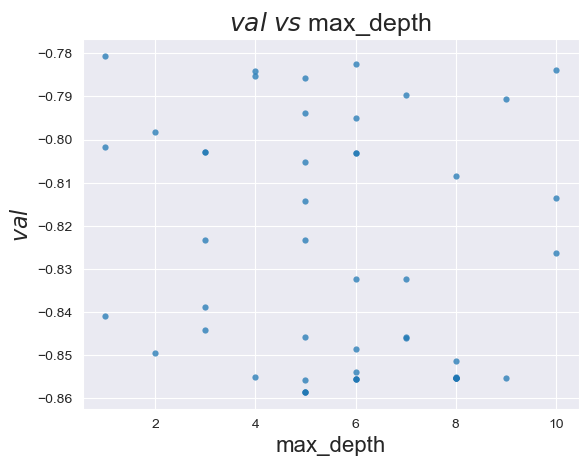

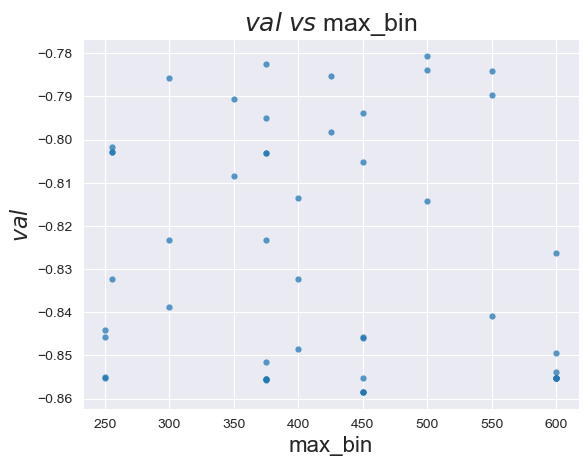

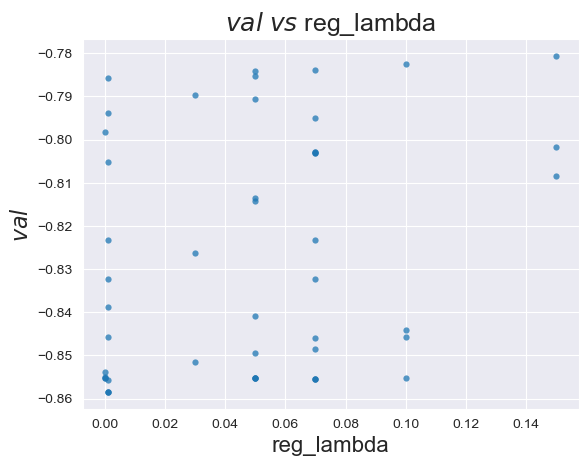

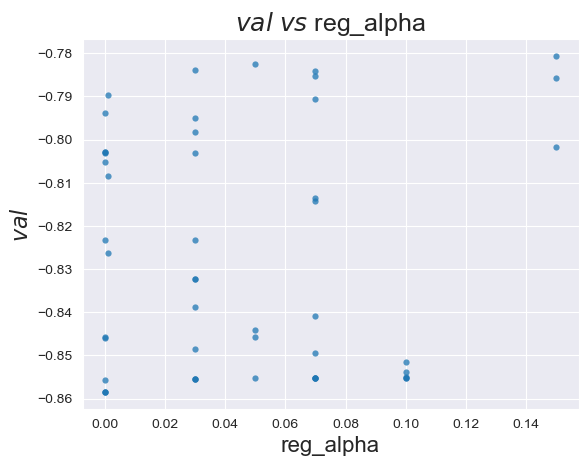

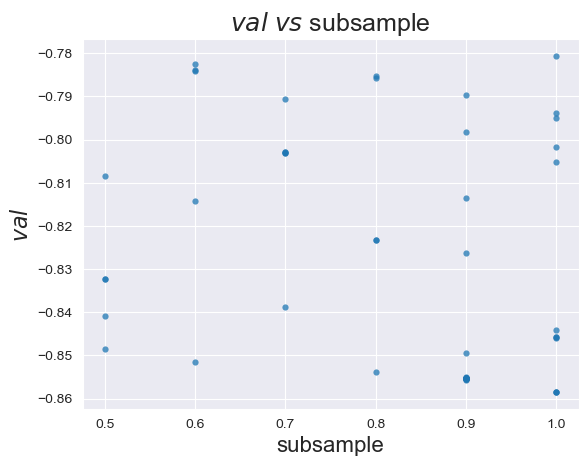

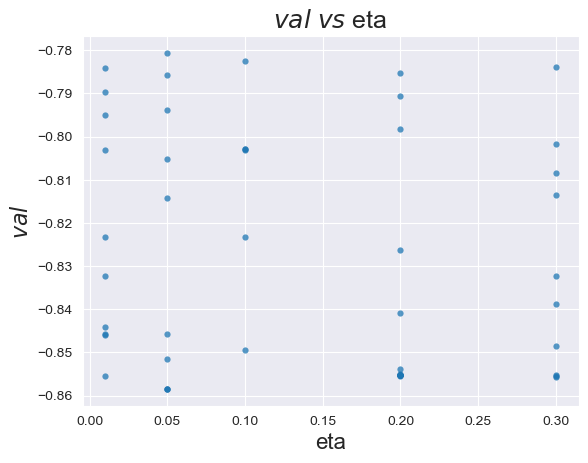

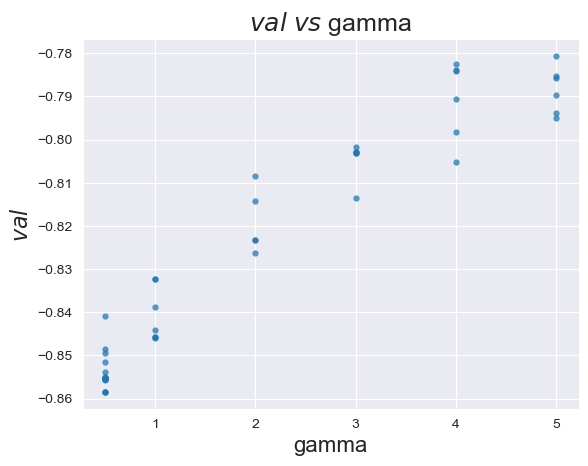

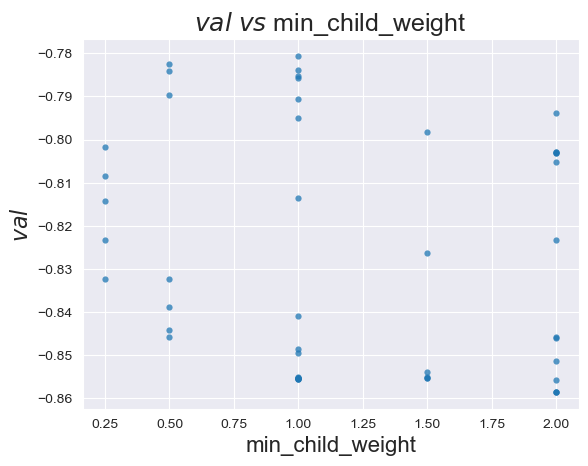

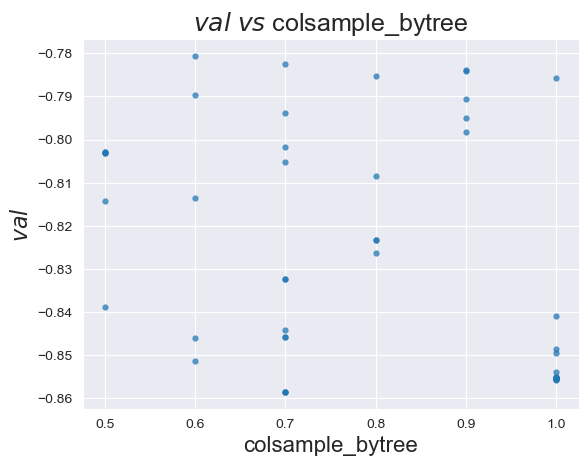

In [49]:
aa = check_result(trials.trials,param_space_list,n=4,plot_val=True,plot_tid=False,output_best = True)

In [50]:
aa

{'objective': 'reg:squaredlogerror',
 'metric': 'mape',
 'learning_rate': 0.01,
 'n_estimators': 30000,
 'max_depth': 5,
 'max_bin': 450,
 'reg_lambda': 0.001,
 'reg_alpha': 0.0,
 'subsample': 1,
 'eta': 0.05,
 'gamma': 0.5,
 'min_child_weight': 2.0,
 'colsample_bytree': 0.7}

In [51]:
model_xgb = xgb.XGBRegressor(**aa, early_stopping_rounds=150, verbose=0)
model_xgb.fit(X_train,train_y, eval_set=valid,eval_metric='mape')

[0]	validation_0-mape:0.57104
[1]	validation_0-mape:0.56757
[2]	validation_0-mape:0.56412
[3]	validation_0-mape:0.56066
[4]	validation_0-mape:0.55722
[5]	validation_0-mape:0.55380


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\Us

[6]	validation_0-mape:0.55038
[7]	validation_0-mape:0.54699
[8]	validation_0-mape:0.54358
[9]	validation_0-mape:0.54019
[10]	validation_0-mape:0.53683
[11]	validation_0-mape:0.53347
[12]	validation_0-mape:0.53011
[13]	validation_0-mape:0.52678
[14]	validation_0-mape:0.52346
[15]	validation_0-mape:0.52016
[16]	validation_0-mape:0.51684
[17]	validation_0-mape:0.51355
[18]	validation_0-mape:0.51025
[19]	validation_0-mape:0.50699
[20]	validation_0-mape:0.50374
[21]	validation_0-mape:0.50050
[22]	validation_0-mape:0.49727
[23]	validation_0-mape:0.49408
[24]	validation_0-mape:0.49087
[25]	validation_0-mape:0.48770
[26]	validation_0-mape:0.48453
[27]	validation_0-mape:0.48137
[28]	validation_0-mape:0.47821
[29]	validation_0-mape:0.47507
[30]	validation_0-mape:0.47194
[31]	validation_0-mape:0.46883
[32]	validation_0-mape:0.46575
[33]	validation_0-mape:0.46267
[34]	validation_0-mape:0.45958
[35]	validation_0-mape:0.45653
[36]	validation_0-mape:0.45347
[37]	validation_0-mape:0.45042
[38]	validat

[266]	validation_0-mape:0.11069
[267]	validation_0-mape:0.11036
[268]	validation_0-mape:0.11005
[269]	validation_0-mape:0.10971
[270]	validation_0-mape:0.10940
[271]	validation_0-mape:0.10909
[272]	validation_0-mape:0.10879
[273]	validation_0-mape:0.10850
[274]	validation_0-mape:0.10822
[275]	validation_0-mape:0.10794
[276]	validation_0-mape:0.10769
[277]	validation_0-mape:0.10739
[278]	validation_0-mape:0.10711
[279]	validation_0-mape:0.10684
[280]	validation_0-mape:0.10657
[281]	validation_0-mape:0.10630
[282]	validation_0-mape:0.10602
[283]	validation_0-mape:0.10576
[284]	validation_0-mape:0.10552
[285]	validation_0-mape:0.10528
[286]	validation_0-mape:0.10502
[287]	validation_0-mape:0.10478
[288]	validation_0-mape:0.10455
[289]	validation_0-mape:0.10434
[290]	validation_0-mape:0.10409
[291]	validation_0-mape:0.10386
[292]	validation_0-mape:0.10364
[293]	validation_0-mape:0.10341
[294]	validation_0-mape:0.10320
[295]	validation_0-mape:0.10300
[296]	validation_0-mape:0.10277
[297]	va

[523]	validation_0-mape:0.08976
[524]	validation_0-mape:0.08976
[525]	validation_0-mape:0.08976
[526]	validation_0-mape:0.08977
[527]	validation_0-mape:0.08977
[528]	validation_0-mape:0.08978
[529]	validation_0-mape:0.08978
[530]	validation_0-mape:0.08978
[531]	validation_0-mape:0.08979
[532]	validation_0-mape:0.08979
[533]	validation_0-mape:0.08980
[534]	validation_0-mape:0.08980
[535]	validation_0-mape:0.08980
[536]	validation_0-mape:0.08981
[537]	validation_0-mape:0.08981
[538]	validation_0-mape:0.08982
[539]	validation_0-mape:0.08982
[540]	validation_0-mape:0.08982
[541]	validation_0-mape:0.08983
[542]	validation_0-mape:0.08983
[543]	validation_0-mape:0.08983
[544]	validation_0-mape:0.08984
[545]	validation_0-mape:0.08984
[546]	validation_0-mape:0.08985
[547]	validation_0-mape:0.08985
[548]	validation_0-mape:0.08985
[549]	validation_0-mape:0.08986
[550]	validation_0-mape:0.08986
[551]	validation_0-mape:0.08986
[552]	validation_0-mape:0.08987
[553]	validation_0-mape:0.08987
[554]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=150,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=0.5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=450, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, metric='mape', min_child_weight=2.0, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=30000,
             n_jobs=None, ...)

In [52]:
xgb_valid_pred = model_xgb.predict(X_valid)
xgb_train_pred = model_xgb.predict(train)
print(rmsle(valid_y, xgb_valid_pred))
print(MAPE(valid_y, xgb_valid_pred))
print(Score(valid_y, xgb_valid_pred))
print(Score(y_train, xgb_train_pred))

0.11416206066285767
0.08958265589259878
4677.8584548484
4975.8743134052565


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\Us

In [ ]:
"""
### With external data###
model_xgb = xgb.XGBRegressor(bagging_fraction=0.84, bagging_freq=4, bagging_seed=9,
              early_stopping_rounds=150, feature_fraction=0.8,
              feature_fraction_seed=9, learning_rate=0.01, max_bin=300,
              metric='mape', min_data_in_leaf=2, min_sum_hessian_in_leaf=2,
              n_estimators=30000, num_leaves=375, objective='regression',
              reg_alpha=0.03, reg_lambda=0.07, verbose=0)
model_xgb.fit(X_train,train_y, eval_set=valid,eval_metric='mape')
"""


In [ ]:
xgb_valid_pred = model_xgb.predict(X_valid)
xgb_train_pred = model_xgb.predict(train)
print(rmsle(valid_y, xgb_valid_pred))
print(MAPE(valid_y, xgb_valid_pred))
print(Score(valid_y, xgb_valid_pred))
print(Score(y_train, xgb_train_pred))

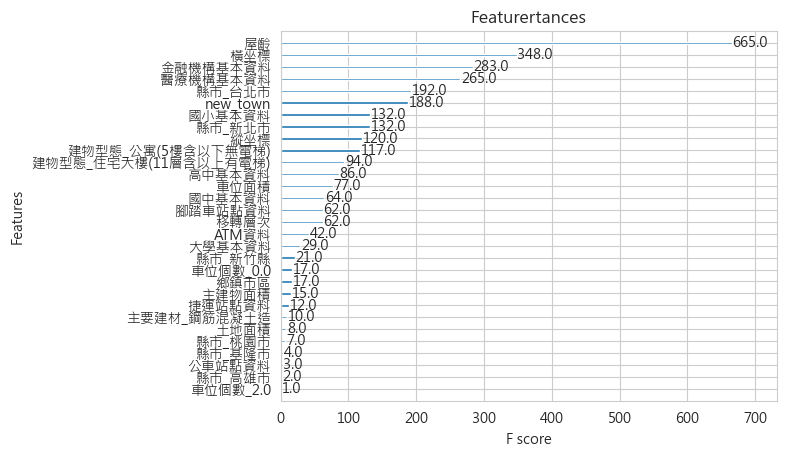

In [54]:
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
xgb.plot_importance(model_xgb, max_num_features=30)

plt.title("Featurertances")
plt.show()

In [55]:
xgb_pred = np.expm1(model_xgb.predict(test.values))

In [56]:
import csv
### Output the predict result to output.csv, the format is corrent (checked)
with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'predicted_price'])

    for i, pred in enumerate(xgb_pred):
        writer.writerow(['PU-' + str(i+1), pred])

In [ ]:
"""submit mape = 12.62969	"""